<a href="https://colab.research.google.com/github/c-daly/Notebooks/blob/main/CS6220_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Preliminaries - Imports/Installs/Data Acquisition

## Imports and Pip Installs

In [ ]:
!pip install gensim tensorflow tensorflow_hub tensorflow_datasets datasets sentence-transformers transformers torch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 12.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 17.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 19.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 42.7 MB/s eta 0:00:00
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125923 sha256=d67db926c64b78a986a820f7d37a5b9b2efe45dc2b3b3e3aa13282f11118d9ec
  Stored in directory: /root/.cache/pip/wheels/62/f2/10/1e606fd5f02395388f74e7462910fe851042f97238cbbd902f
Successfully built sentence-transformers


In [ ]:
import datasets
from datasets import load_dataset
import gensim.downloader as api
from gensim.models import KeyedVectors
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import tensorflow_hub as hub
import tensorflow as tf
import tensorflow_datasets as tfds
import urllib
import zipfile
from sklearn.preprocessing import normalize
from sklearn.metrics import r2_score
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, precision_recall_curve, auc
from sentence_transformers import SentenceTransformer
import h5py

## Fetch Data

In [ ]:
# Load the IMDB dataset
(imdb_train_data, imdb_test_data), ds_info = tfds.load(
    'imdb_reviews',
    split=['train', 'test'],
    as_supervised=True,
    with_info=True)

#def load_imdb_from_datasets():
#  return load_dataset("imdb")

def load_wordsim_353():
    # URL of the dataset
    url = "http://www.gabrilovich.com/resources/data/wordsim353/wordsim353.zip"

    # Download the dataset
    urllib.request.urlretrieve(url, "wordsim353.zip")

    # Get the path to the downloaded zip file
    zipfile_path = os.path.join(os.getcwd(), "wordsim353.zip")


    # Unzip the dataset
    with zipfile.ZipFile(zipfile_path, 'r') as zip_ref:
        zip_ref.extractall('wordsim353')
    data = pd.read_csv('wordsim353/combined.csv', sep=',')
    return data

def load_rice_stsb():
    return load_dataset("glue", "stsb")

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteAS1HWE/imdb_reviews-train.tfrecord…

Generating test examples...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteAS1HWE/imdb_reviews-test.tfrecord*…

Generating unsupervised examples...:   0%|          | 0/50000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteAS1HWE/imdb_reviews-unsupervised.t…

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


**If you have previously saved h5 files stored in drive, use this cell to copy them**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# copy stored embeddings from my drive
!cp ./drive/MyDrive/data/*.h5 .

Mounted at /content/drive


**Plot Data**

In [ ]:
# Plotting functions
def plot_confusion_matrix(cm, classes, title='Confusion Matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    #for i in range(normalized_conf_mat.shape[0]):
    for i in range(cm.shape[0]):
      for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], '.2f'),
                 horizontalalignment="center", color="white" if cm[i, j] > 0.5 else "black")


def plot_roc_curve(fpr, tpr, roc_auc, model=None, color=None):
    if not color:
      color = 'darkorange'
    if not model:
      model = 'ROC curve'
    label_text = f'{model} area = {roc_auc:.2f}'
    plt.plot(fpr, tpr, color=color, label=label_text)
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")

def plot_precision_recall_curve(precision, recall, pr_auc, model=None, color=None):
    if not color:
      color = 'b'

    if not model:
      model = 'PR curve'
    label_text = f'{model} area = {pr_auc:.2f}'
    plt.plot(recall, precision, color=color, label=label_text)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc="lower left")

def plot_histogram_probabilities(probs, title="Histogram of Predicted Probabilities"):
    plt.hist(probs, bins=10, edgecolor='k', alpha=0.7)
    plt.xlim([0, 1])
    plt.title(title)
    plt.xlabel('Predicted Probability of Positive Class')
    plt.ylabel('Frequency')

# Common Functions

In [ ]:
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk
import numpy as np

nltk.download('punkt')
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

def tokenize_and_preprocess(text):
    # Tokenize
    tokens = word_tokenize(text)
    # Convert to lowercase
    tokens = [word.lower() for word in tokens]
    # Remove punctuations
    tokens = [word for word in tokens if word not in string.punctuation]
    # Remove stopwords
    tokens = [word for word in tokens if word not in stop_words]
    return ' '.join(tokens)

def cosine_similarity(vec1, vec2):
    return np.dot(vec1, vec2) / (np.linalg.norm(vec1) * np.linalg.norm(vec2))

def get_embedding(text, model):
    embeddings = [model[word] for word in text if word in model]
    if len(embeddings) == 0:
        return np.zeros(model.vector_size)
    return np.mean(embeddings, axis=0)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


# Word2Vec

In [ ]:
word2vec_model = api.load("word2vec-google-news-300")

[============================================------] 88.8% 1475.9/1662.8MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[=============================================-----] 90.6% 1506.2/1662.8MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[==============================================----] 92.4% 1535.9/1662.8MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[===============================================---] 94.3% 1568.6/1662.8MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[=================================================-] 100.0% 1662.4/1662.8MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



## Word Similarity

In [ ]:
sim_data = load_wordsim_353()

In [ ]:
import numpy as np

def cosine_similarity(vec1, vec2):
    return np.dot(vec1, vec2) / (np.linalg.norm(vec1) * np.linalg.norm(vec2))

# Compute similarities for WordSim-353 dataset
ws_w2v_computed_similarities = []
for _, row in sim_data.iterrows():
    word1, word2 = row['Word 1'], row['Word 2']
    if word1 in word2vec_model and word2 in word2vec_model:
        similarity = cosine_similarity(word2vec_model[word1], word2vec_model[word2])
        ws_w2v_computed_similarities.append(similarity)
    else:
        ws_w2v_computed_similarities.append(None)  # or some placeholder for words not in the vocab


In [ ]:
import numpy as np

sim_data_word1 = sim_data['Word 1']
sim_data_word2 = sim_data['Word 2']
human_scores = sim_data['Human (mean)']
ws_w2v_embed1 = word2vec_model[sim_data_word1]
ws_w2v_embed2 = word2vec_model[sim_data_word2]
ws_w2v_computed_similarity = ((ws_w2v_embed1 * ws_w2v_embed2)/(np.linalg.norm(ws_w2v_embed2)*np.linalg.norm(ws_w2v_embed1))).sum(axis=1)
ws_w2v_computed_similarity_scaled = ((ws_w2v_computed_similarity + 1)/2) * 10

In [ ]:
ws_w2v_computed_similarities_scaled = np.array(ws_w2v_computed_similarities) * 10

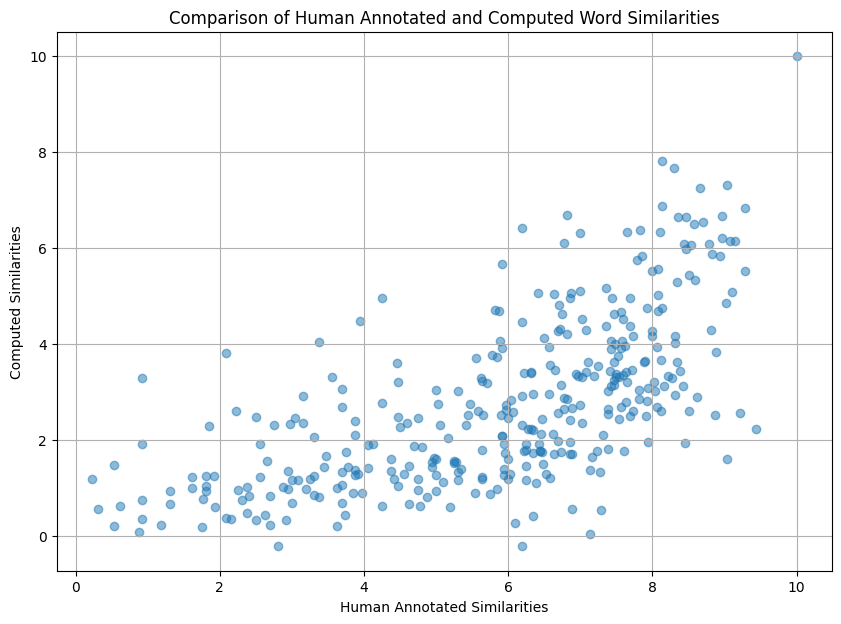

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 7))
plt.scatter(human_scores, ws_w2v_computed_similarities_scaled, alpha=0.5)
plt.xlabel('Human Annotated Similarities')
plt.ylabel('Computed Similarities')
plt.title('Comparison of Human Annotated and Computed Word Similarities')
plt.grid(True)
plt.show()

In [ ]:
from scipy.stats import pearsonr, spearmanr

w2v_ws_pearson_corr, _ = pearsonr(human_scores, ws_w2v_computed_similarities_scaled)
w2v_ws_spearman_corr, _ = spearmanr(human_scores, ws_w2v_computed_similarities_scaled)

print(f"Pearson Correlation: {w2v_ws_pearson_corr:.3f}")
print(f"Spearman Correlation: {w2v_ws_spearman_corr:.3f}")

Pearson Correlation: 0.653
Spearman Correlation: 0.700


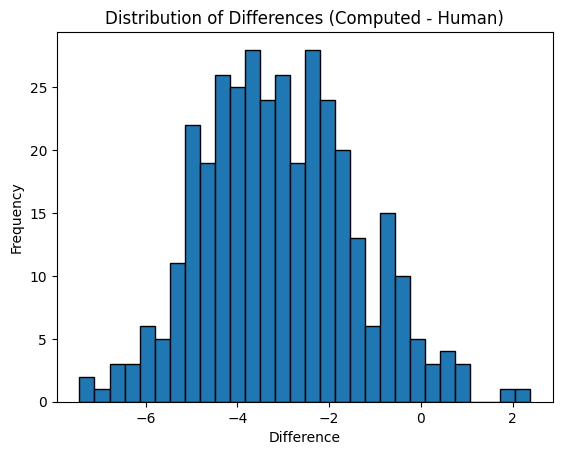

In [ ]:
differences = [comp - human for comp, human in zip(ws_w2v_computed_similarities_scaled, human_scores)]
plt.hist(differences, bins=30, edgecolor='black')
plt.title('Distribution of Differences (Computed - Human)')
plt.xlabel('Difference')
plt.ylabel('Frequency')
plt.show()

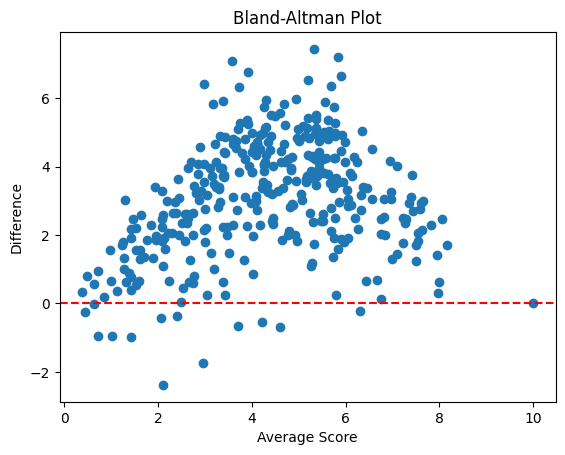

In [ ]:
averages = (human_scores + ws_w2v_computed_similarities_scaled) / 2
differences = human_scores - ws_w2v_computed_similarities_scaled

plt.scatter(averages, differences)
plt.axhline(0, color='red', linestyle='--')  # Line of no difference
plt.xlabel('Average Score')
plt.ylabel('Difference')
plt.title('Bland-Altman Plot')
plt.show()

## Sentence Similarity

In [ ]:
sentence_similarity_data = load_rice_stsb()

Generating train split:   0%|          | 0/5749 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1500 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1379 [00:00<?, ? examples/s]

In [ ]:
train_sentence_similarity_data = sentence_similarity_data['train']
test_sentence_similarity_data = sentence_similarity_data['test']
validation_sentence_similarity_data = sentence_similarity_data['validation']

In [ ]:
ssim_train_labels = train_sentence_similarity_data['label']
ssim_test_labels = test_sentence_similarity_data['label']
ssim_val_labels = validation_sentence_similarity_data['label']

In [ ]:
w2v_ssim_train_embeddings1 = [get_embedding(text, word2vec_model) for text in train_sentence_similarity_data['sentence1']]
w2v_ssim_train_embeddings2 = [get_embedding(text, word2vec_model) for text in train_sentence_similarity_data['sentence2']]

In [ ]:
w2v_ssim_test_embeddings1 = [get_embedding(text, word2vec_model) for text in test_sentence_similarity_data['sentence1']]
w2v_ssim_test_embeddings2 = [get_embedding(text, word2vec_model) for text in test_sentence_similarity_data['sentence2']]

In [ ]:
w2v_ssim_val_embeddings1 = [get_embedding(text, word2vec_model) for text in validation_sentence_similarity_data['sentence1']]
w2v_ssim_val_embeddings2 = [get_embedding(text, word2vec_model) for text in validation_sentence_similarity_data['sentence2']]

In [ ]:
# Compute pairwise cosine similarity for each pair of embeddings
normalized_w2v_ssim_train_embed1 = normalize(w2v_ssim_train_embeddings1)
normalized_w2v_ssim_train_embed2 = normalize(w2v_ssim_train_embeddings2)
normalized_w2v_ssim_validation_embed1 = normalize(w2v_ssim_val_embeddings1)
normalized_w2v_ssim_validation_embed2 = normalize(w2v_ssim_val_embeddings2)

w2v_ssim_train_pairwise_similarity = (normalized_w2v_ssim_train_embed1 * normalized_w2v_ssim_train_embed2).sum(axis=1)
w2v_ssim_validation_pairwise_similarity = (normalized_w2v_ssim_validation_embed1 * normalized_w2v_ssim_validation_embed2).sum(axis=1)

w2v_ssim_train_pairwise_similarity = w2v_ssim_train_pairwise_similarity * 5
w2v_ssim_validation_pairwise_similarity = w2v_ssim_validation_pairwise_similarity * 5

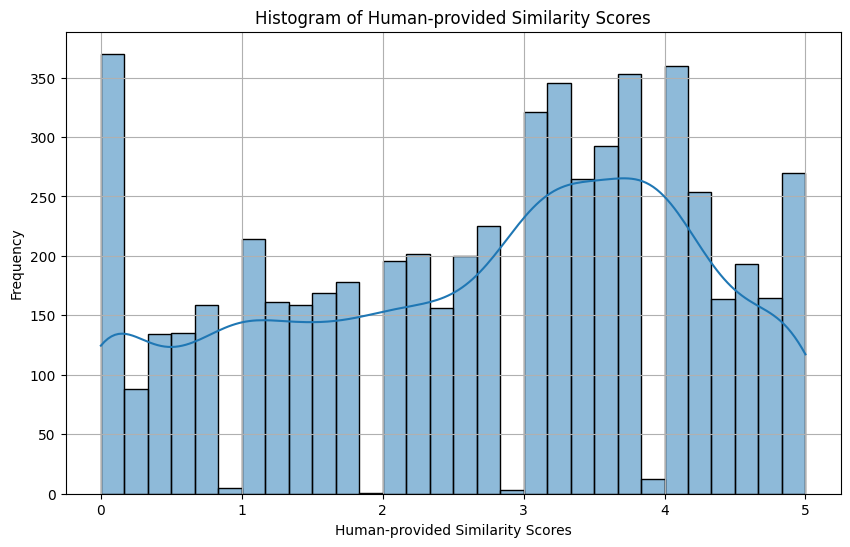

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(ssim_train_labels, bins=30, kde=True)
plt.title("Histogram of Human-provided Similarity Scores")
plt.xlabel("Human-provided Similarity Scores")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

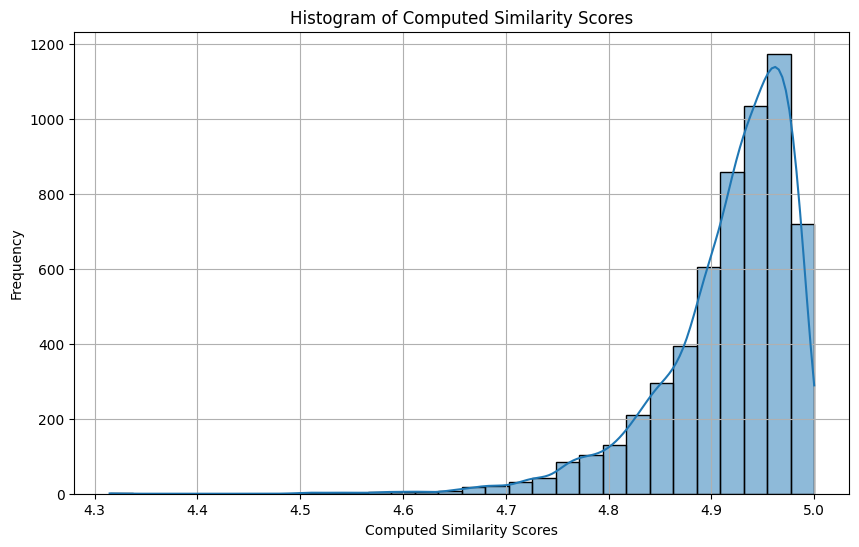

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(w2v_ssim_train_pairwise_similarity, bins=30, kde=True)
plt.title("Histogram of Computed Similarity Scores")
plt.xlabel("Computed Similarity Scores")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

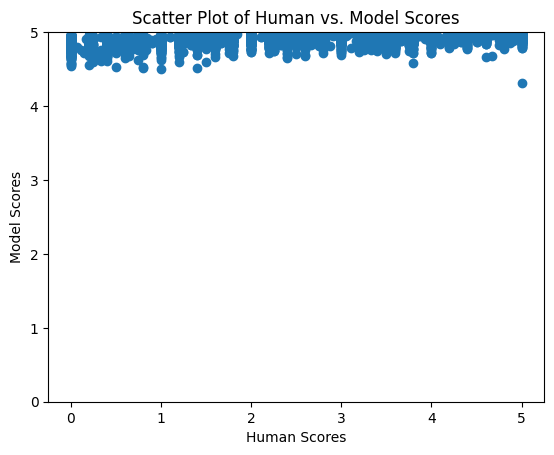

In [ ]:
import matplotlib.pyplot as plt

plt.ylim(0,5)
plt.scatter(ssim_train_labels, w2v_ssim_train_pairwise_similarity)
plt.xlabel('Human Scores')
plt.ylabel('Model Scores')
plt.title('Scatter Plot of Human vs. Model Scores')
plt.show()

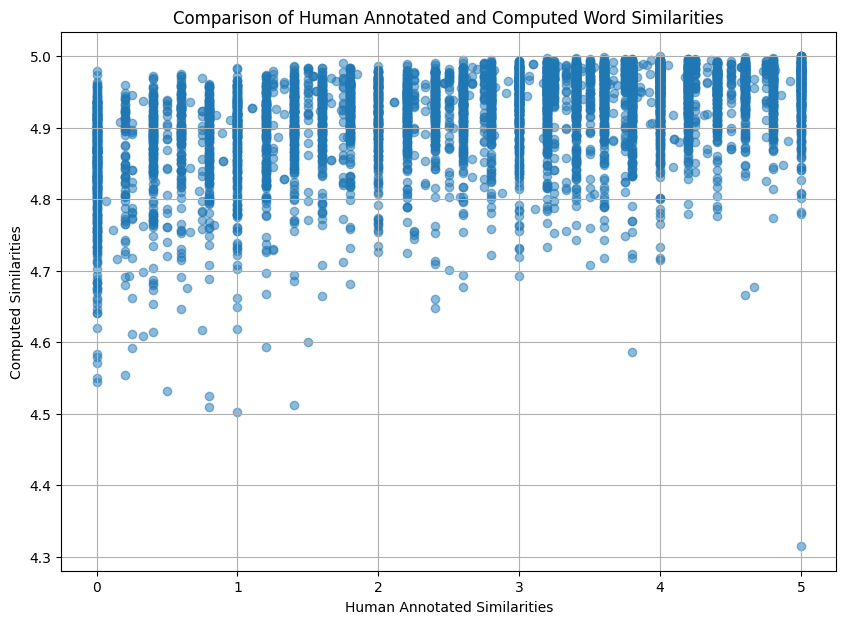

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 7))
plt.scatter(ssim_train_labels, w2v_ssim_train_pairwise_similarity, alpha=0.5)
plt.xlabel('Human Annotated Similarities')
plt.ylabel('Computed Similarities')
plt.title('Comparison of Human Annotated and Computed Word Similarities')
plt.grid(True)
plt.show()

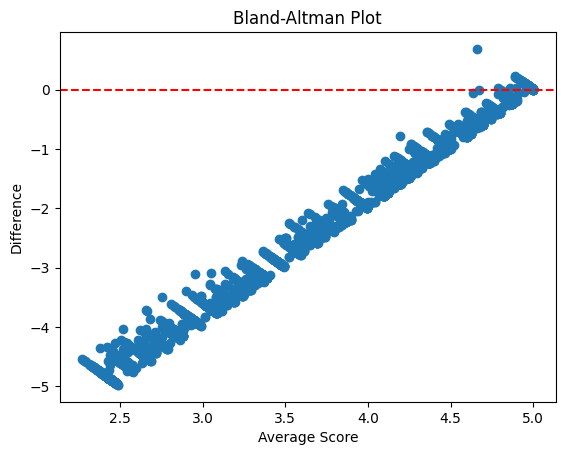

In [ ]:
averages = (ssim_train_labels + w2v_ssim_train_pairwise_similarity) / 2
differences = ssim_train_labels - w2v_ssim_train_pairwise_similarity

plt.scatter(averages, differences)
plt.axhline(0, color='red', linestyle='--')  # Line of no difference
plt.xlabel('Average Score')
plt.ylabel('Difference')
plt.title('Bland-Altman Plot')
plt.show()

In [ ]:
w2v_ss_pearson_corr, _ = pearsonr(ssim_train_labels, w2v_ssim_train_pairwise_similarity)
w2v_ss_spearman_corr, _ = spearmanr(ssim_train_labels, w2v_ssim_train_pairwise_similarity)

print(f"Pearson Correlation: {w2v_ss_pearson_corr:.3f}")
print(f"Spearman Correlation: {w2v_ss_spearman_corr:.3f}")

Pearson Correlation: 0.458
Spearman Correlation: 0.474


## Sentiment Classifiation (IMDB)

In [ ]:
#import re
#import string

#def get_w2v_embedding(text):
#    model = word2vec_model
#    embedding = np.mean([model[word] for word in text if word in model], axis=0)
#    return embedding


#def tf_get_embedding(text):
#    # Use tf.numpy_function to wrap the get_embedding function
#    return tf.numpy_function(get_w2v_embedding, [text], Tout=tf.float32)

# 'dataset' is your TensorFlow Dataset object
#imdb_w2v_train_data = imdb_train_data.map(
#    lambda text, label: (tf_get_embedding(text), label),
#    num_parallel_calls=tf.data.AUTOTUNE)

#imdb_w2v_test_data = imdb_test_data.map(
#    lambda text, label: (tf_get_embedding(text), label),
#    num_parallel_calls=tf.data.AUTOTUNE)


#imdb_train_labels = imdb_w2v_train_data.map(lambda x, y: y)
#imdb_w2v_train_embeddings = imdb_w2v_train_data.map(lambda x, y: x)

#imdb_test_labels = imdb_w2v_test_data.map(lambda x, y: y)
#imdb_test_embeddings = imdb_w2v_test_data.map(lambda x,y: x)

In [ ]:
#def get_embedding(text, model):
#    embeddings = [model[word] for word in text if word in model]
#    if len(embeddings) == 0:
#        return np.zeros(model.vector_size)
#    return np.mean(embeddings, axis=0)

w2v_imdb_train_embeddings = np.array([get_embedding(str(text.numpy()), word2vec_model) for text, label in imdb_train_data])
w2v_imdb_test_embeddings = np.array([get_embedding(str(text.numpy()), word2vec_model) for text, label in imdb_test_data])


In [ ]:
imdb_train_labels = imdb_train_data.map(lambda x,y: y)
imdb_train_labels = [label for label in imdb_train_labels]

In [ ]:
imdb_test_labels = imdb_test_data.map(lambda x,y: y)
imdb_test_labels = [label for label in imdb_test_labels]

In [ ]:
w2v_sc_clf = LogisticRegression().fit(w2v_imdb_train_embeddings, imdb_train_labels)


In [ ]:
w2v_sc_accuracy = w2v_sc_clf.score(w2v_imdb_test_embeddings, imdb_test_labels)
print(f"Accuracy: {w2v_sc_accuracy * 100:.2f}%")

Accuracy: 61.07%


In [ ]:
from sklearn.metrics import accuracy_score
w2v_sc_test_ypred = w2v_sc_clf.predict(w2v_imdb_test_embeddings)
w2v_sc_accuracy = accuracy_score(imdb_test_labels, w2v_sc_test_ypred)


In [ ]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, roc_curve, precision_recall_curve, auc, classification_report
import matplotlib.pyplot as plt

# Predict probabilities
w2v_sc_test_probabilities = w2v_sc_clf.predict_proba(w2v_imdb_test_embeddings)
w2v_sc_predicted_labels = (w2v_sc_test_probabilities[:,1] > 0.5).astype(int)
# Get confusion matrix
w2v_sc_conf_mat = confusion_matrix(imdb_test_labels, w2v_sc_test_ypred)

# ROC curve
w2v_sc_fpr, w2v_sc_tpr, _ = roc_curve(imdb_test_labels, w2v_sc_test_ypred)
w2v_sc_roc_auc = auc(w2v_sc_fpr, w2v_sc_tpr)

# Precision-Recall curve
w2v_sc_precision, w2v_sc_recall, _ = precision_recall_curve(imdb_test_labels, w2v_sc_test_ypred)
w2v_sc_pr_auc = auc(w2v_sc_recall, w2v_sc_precision)

w2v_sc_accuracy = accuracy_score(imdb_test_labels, w2v_sc_test_ypred)
#w2v_sc_accuracy, w2v_sc_conf_mat, w2v_sc_roc_auc, w2v_sc_pr_auc
w2v_sc_classification_report = classification_report(imdb_test_labels, w2v_sc_test_ypred, output_dict=True)
print(w2v_sc_classification_report)

{'0': {'precision': 0.6097232135776033, 'recall': 0.61504, 'f1-score': 0.6123700665100162, 'support': 12500}, '1': {'precision': 0.6116536195625858, 'recall': 0.60632, 'f1-score': 0.6089751315736611, 'support': 12500}, 'accuracy': 0.61068, 'macro avg': {'precision': 0.6106884165700945, 'recall': 0.61068, 'f1-score': 0.6106725990418387, 'support': 25000}, 'weighted avg': {'precision': 0.6106884165700945, 'recall': 0.61068, 'f1-score': 0.6106725990418387, 'support': 25000}}


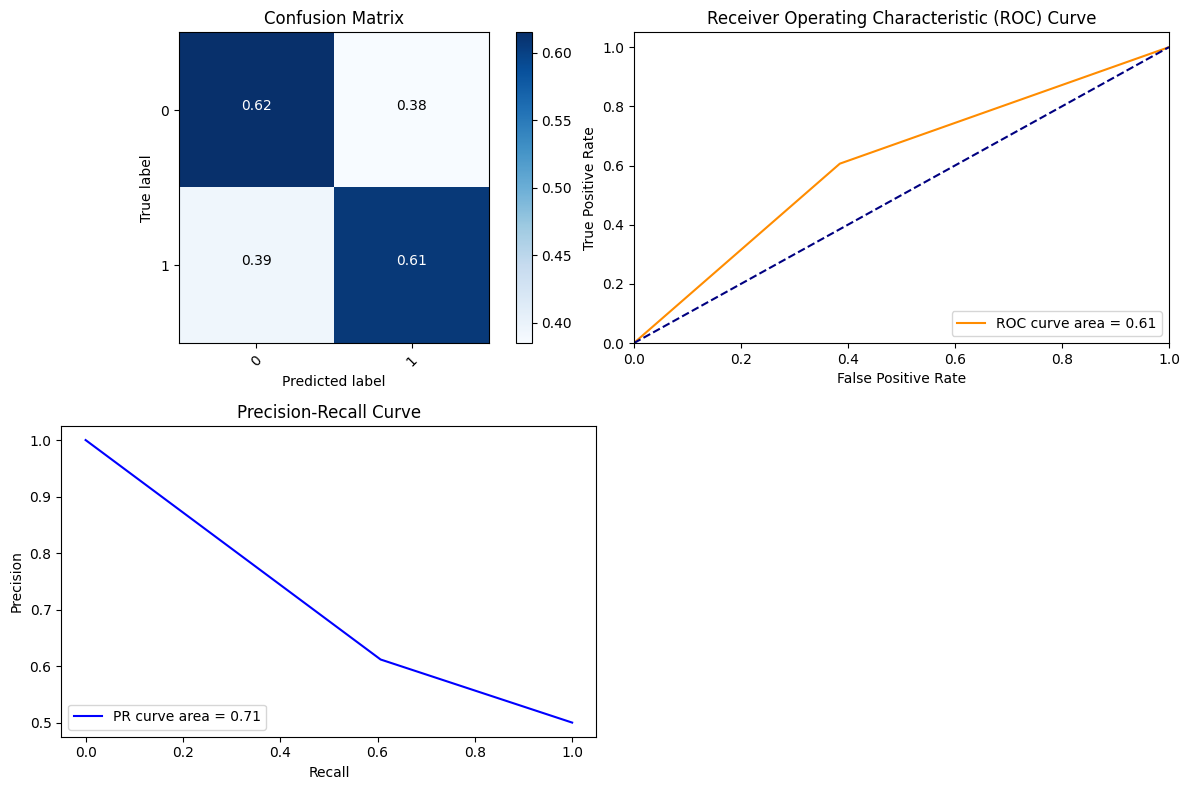

In [ ]:
plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 1)

w2v_sc_normalized_conf_mat = w2v_sc_conf_mat.astype('float') / w2v_sc_conf_mat.sum(axis=1)[:, np.newaxis]
plot_confusion_matrix(w2v_sc_normalized_conf_mat, classes=['0', '1'])
plt.subplot(2, 2, 2)
plot_roc_curve(w2v_sc_fpr, w2v_sc_tpr, w2v_sc_roc_auc)
plt.subplot(2, 2, 3)
plot_precision_recall_curve(w2v_sc_precision, w2v_sc_recall, w2v_sc_pr_auc)

plt.tight_layout()
plt.show()

## Sentence Entailment


In [ ]:
def filter_negative_ones(example):
    return example['label'] != -1

snli_dataset = datasets.load_dataset('snli')
snli_dataset = snli_dataset.filter(filter_negative_ones)

Downloading:   0%|          | 0.00/1.93k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.26M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/65.9M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.26M [00:00<?, ?B/s]

Filter:   0%|          | 0/10000 [00:00<?, ? examples/s]

Filter:   0%|          | 0/550152 [00:00<?, ? examples/s]

Filter:   0%|          | 0/10000 [00:00<?, ? examples/s]

In [ ]:
snli_train_data = snli_dataset['train']
snli_test_data = snli_dataset['test']
snli_validation_data = snli_dataset['validation']

In [ ]:
snli_train_premises = snli_train_data['premise']
snli_train_hypotheses = snli_train_data['hypothesis']
snli_train_labels = snli_train_data['label']

snli_validation_premises = snli_validation_data['premise']
snli_validation_hypotheses = snli_validation_data['hypothesis']
snli_validation_labels = snli_validation_data['label']

In [ ]:
import tensorflow as tf
from transformers import BertTokenizer, TFBertModel

def batch_cosine_similarity(embeddings1, embeddings2):
    normalized_embeddings1 = tf.nn.l2_normalize(embeddings1, axis=1)
    normalized_embeddings2 = tf.nn.l2_normalize(embeddings2, axis=1)
    return tf.reduce_sum(tf.multiply(normalized_embeddings1, normalized_embeddings2), axis=1)

#def get_batch_w2v_embedding(batch):
#  print(f"Batch {str(batch)}")
#  embeddings = []
#  for example in batch:
#    print(example)
#    embeddings.append(get_embedding(example, word2vec_model))

snli_train_dataset = tf.data.Dataset.from_tensor_slices((snli_train_premises, snli_train_hypotheses, snli_train_labels))
snli_validation_dataset = tf.data.Dataset.from_tensor_slices((snli_validation_premises, snli_validation_hypotheses, snli_validation_labels))

batch_size = 512
snli_w2v_train_dataset = snli_train_dataset.batch(batch_size)
snli_w2v_train_cat_embeddings = []

for batch_premises, batch_hypotheses, batch_labels in snli_w2v_train_dataset:
    snli_w2v_train_premise_embeddings = [np.array(get_embedding(premise, word2vec_model)) for premise in batch_premises.numpy()]
    snli_w2v_train_hypothesis_embeddings = [np.array(get_embedding(hypothesis, word2vec_model)) for hypothesis in batch_hypotheses.numpy()]
    snli_w2v_train_cat_embeddings.append(np.hstack((snli_w2v_train_premise_embeddings, snli_w2v_train_hypothesis_embeddings)))


In [ ]:
snli_w2v_validation_dataset = snli_validation_dataset.batch(batch_size)
snli_w2v_val_cat_embeddings = []
for batch_premises, batch_hypotheses, batch_labels in snli_w2v_validation_dataset:
    snli_w2v_val_premise_embeddings = [np.array(get_embedding(premise, word2vec_model)) for premise in batch_premises.numpy()]
    snli_w2v_val_hypothesis_embeddings = [np.array(get_embedding(hypothesis, word2vec_model)) for hypothesis in batch_hypotheses.numpy()]
    snli_w2v_val_cat_embeddings.append(np.hstack((snli_w2v_val_premise_embeddings, snli_w2v_val_hypothesis_embeddings)))

    #snli_w2v_val_premise_embeddings = get_embedding(batch_premises.numpy().astype(str), word2vec_model)
    #snli_w2v_val_hypothesis_embeddings = get_embedding(batch_hypotheses.numpy().astype(str), word2vec_model)
    #snli_w2v_val_cat_embeddings.append(np.hstack((snli_w2v_val_premise_embeddings, snli_w2v_val_hypothesis_embeddings)))

In [ ]:
from keras.optimizers import Adam

embedding_dim = 600  # For 2 concatenated word2vec vectors

model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(embedding_dim,)),
    tf.keras.layers.Dense(96, activation='relu'),
    tf.keras.layers.Dropout(0.2),

    tf.keras.layers.Dense(96, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(48, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    #tf.keras.layers.Dense(48, activation='relu'),
    #tf.keras.layers.Dropout(0.2),
    #tf.keras.layers.Dense(24, activation='relu'),
    #tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(3, activation='softmax')
])

opt = Adam()

w2v_se_model = model
w2v_se_model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
snli_w2v_train_flat_embeddings = []
for batch in snli_w2v_train_cat_embeddings:
  for embedding in batch:
    snli_w2v_train_flat_embeddings.append(np.array(embedding))

snli_w2v_train_flat_embeddings = np.array(snli_w2v_train_flat_embeddings)

In [ ]:
w2v_se_model_fit = w2v_se_model.fit(snli_w2v_train_flat_embeddings, np.array(snli_train_labels), epochs=10)

Epoch 1/10
17168/17168 [==============================] - 57s 3ms/step - loss: 1.0644 - accuracy: 0.4200
Epoch 2/10
17168/17168 [==============================] - 51s 3ms/step - loss: 1.0507 - accuracy: 0.4403
Epoch 3/10
17168/17168 [==============================] - 51s 3ms/step - loss: 1.0464 - accuracy: 0.4454
Epoch 4/10
17168/17168 [==============================] - 51s 3ms/step - loss: 1.0441 - accuracy: 0.4477
Epoch 5/10
17168/17168 [==============================] - 50s 3ms/step - loss: 1.0426 - accuracy: 0.4486
Epoch 6/10
17168/17168 [==============================] - 51s 3ms/step - loss: 1.0414 - accuracy: 0.4502
Epoch 7/10
17168/17168 [==============================] - 51s 3ms/step - loss: 1.0407 - accuracy: 0.4505
Epoch 8/10
17168/17168 [==============================] - 51s 3ms/step - loss: 1.0381 - accuracy: 0.4534
Epoch 9/10
17168/17168 [==============================] - 51s 3ms/step - loss: 1.0366 - accuracy: 0.4559
Epoch 10/10
17168/17168 [==============================

In [ ]:
snli_w2v_val_flat_embeddings = []
for batch in snli_w2v_val_cat_embeddings:
  for embedding in batch:
    snli_w2v_val_flat_embeddings.append(np.array(embedding))

snli_w2v_val_flat_embeddings = np.array(snli_w2v_val_flat_embeddings)

In [ ]:
w2v_snli_eval = model.evaluate(snli_w2v_val_flat_embeddings, np.array(snli_validation_labels))

308/308 [==============================] - 1s 2ms/step - loss: 1.0188 - accuracy: 0.4799


# FastText

In [ ]:
import urllib.request
import zipfile
from gensim.models import KeyedVectors

# Download the FastText model
url = "https://dl.fbaipublicfiles.com/fasttext/vectors-english/crawl-300d-2M.vec.zip"
filename = "crawl-300d-2M.vec.zip"
urllib.request.urlretrieve(url, filename)

# Unzip the downloaded file
with zipfile.ZipFile(filename, 'r') as zip_ref:
    zip_ref.extractall()

# Load the model using gensim
ft_model_path = "crawl-300d-2M.vec"
ft_model = KeyedVectors.load_word2vec_format(ft_model_path, binary=False)

In [ ]:
def get_fasttext_embedding(text, model):
    tokens = text.split()
    embeddings = [model[word] for word in tokens if word in model]
    if len(embeddings) == 0:
        return np.zeros(model.vector_size)
    return np.mean(embeddings, axis=0)

## Word Similarity

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

def compute_cosine_similarity(word1, word2, model):
    if word1 in model and word2 in model:
        emb1 = model[word1].reshape(1, -1)
        emb2 = model[word2].reshape(1, -1)
        return cosine_similarity(emb1, emb2)[0][0]
    else:
        return None  # Return None if any word is not in the model's vocabulary
sim_data['computed_similarity'] = sim_data.apply(lambda row: compute_cosine_similarity(row['Word 1'], row['Word 2'], ft_model), axis=1)


In [ ]:
from scipy.stats import spearmanr

# Remove rows where computed_similarity is None
filtered_sim_data = sim_data.dropna(subset=['computed_similarity'])

correlation, _ = spearmanr(filtered_sim_data['Human (mean)'], filtered_sim_data['computed_similarity'])
print(f"Spearman's rank correlation: {correlation:.4f}")

Spearman's rank correlation: 0.7914


In [ ]:
ft_ws_pearson_corr, _ = pearsonr(human_scores, filtered_sim_data['computed_similarity'])
ft_ws_spearman_corr, _ = spearmanr(human_scores, filtered_sim_data['computed_similarity'])

print(f"Pearson Correlation: {ft_ws_pearson_corr:.3f}")
print(f"Spearman Correlation: {ft_ws_spearman_corr:.3f}")

Pearson Correlation: 0.740
Spearman Correlation: 0.791


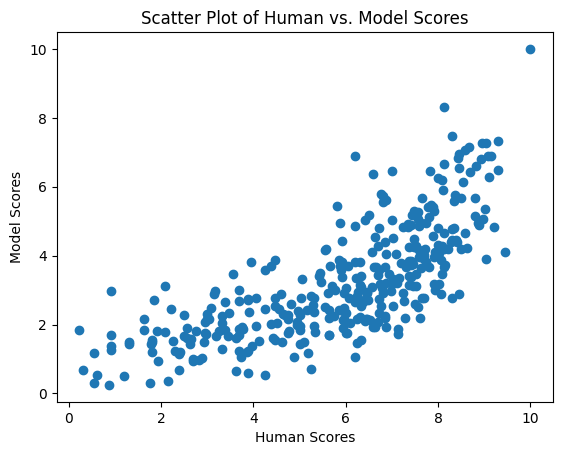

In [ ]:
import matplotlib.pyplot as plt
plt.scatter(filtered_sim_data['Human (mean)'], filtered_sim_data['computed_similarity'] * 10)
plt.xlabel('Human Scores')
plt.ylabel('Model Scores')
plt.title('Scatter Plot of Human vs. Model Scores')
plt.show()

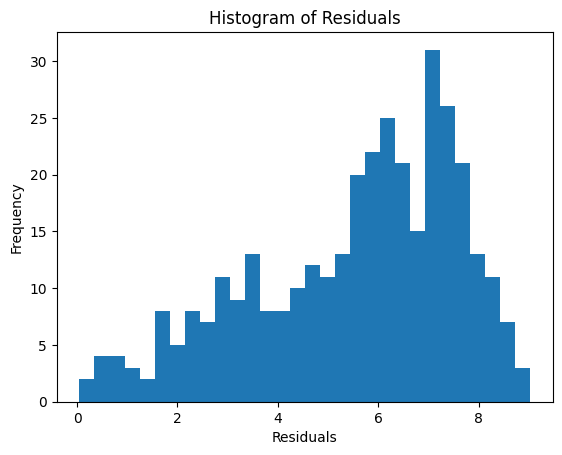

In [ ]:
residuals = filtered_sim_data['Human (mean)'] - filtered_sim_data['computed_similarity']
plt.hist(residuals, bins=30)
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Histogram of Residuals')
plt.show()

In [ ]:
from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(filtered_sim_data['Human (mean)'], filtered_sim_data['computed_similarity'])
print(f"Mean Absolute Error: {mae:.4f}")

Mean Absolute Error: 5.5315


In [ ]:
from sklearn.metrics import mean_squared_error
rmse = mean_squared_error(filtered_sim_data['Human (mean)'], filtered_sim_data['computed_similarity'], squared=False)
print(f"Root Mean Square Error: {rmse:.4f}")

Root Mean Square Error: 5.9004


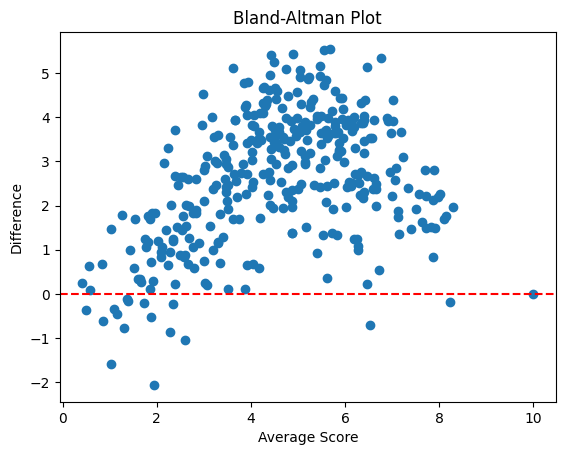

In [ ]:
averages = (human_scores + filtered_sim_data['computed_similarity'] * 10) / 2
differences = human_scores - filtered_sim_data['computed_similarity'] * 10

plt.scatter(averages, differences)
plt.axhline(0, color='red', linestyle='--')  # Line of no difference
plt.xlabel('Average Score')
plt.ylabel('Difference')
plt.title('Bland-Altman Plot')
plt.show()

## Sentiment Classification

In [ ]:
ft_imdb_train_embeddings = np.array([get_fasttext_embedding(text.numpy().decode('utf-8'), ft_model) for text, label in imdb_train_data])
ft_imdb_test_embeddings = np.array([get_fasttext_embedding(text.numpy().decode('utf-8'), ft_model) for text, label in imdb_test_data])


In [ ]:
print(imdb_train_labels)

[<tf.Tensor: shape=(), dtype=int64, numpy=0>, <tf.Tensor: shape=(), dtype=int64, numpy=0>, <tf.Tensor: shape=(), dtype=int64, numpy=0>, <tf.Tensor: shape=(), dtype=int64, numpy=1>, <tf.Tensor: shape=(), dtype=int64, numpy=1>, <tf.Tensor: shape=(), dtype=int64, numpy=1>, <tf.Tensor: shape=(), dtype=int64, numpy=0>, <tf.Tensor: shape=(), dtype=int64, numpy=0>, <tf.Tensor: shape=(), dtype=int64, numpy=0>, <tf.Tensor: shape=(), dtype=int64, numpy=0>, <tf.Tensor: shape=(), dtype=int64, numpy=0>, <tf.Tensor: shape=(), dtype=int64, numpy=1>, <tf.Tensor: shape=(), dtype=int64, numpy=1>, <tf.Tensor: shape=(), dtype=int64, numpy=0>, <tf.Tensor: shape=(), dtype=int64, numpy=1>, <tf.Tensor: shape=(), dtype=int64, numpy=0>, <tf.Tensor: shape=(), dtype=int64, numpy=1>, <tf.Tensor: shape=(), dtype=int64, numpy=1>, <tf.Tensor: shape=(), dtype=int64, numpy=1>, <tf.Tensor: shape=(), dtype=int64, numpy=0>, <tf.Tensor: shape=(), dtype=int64, numpy=1>, <tf.Tensor: shape=(), dtype=int64, numpy=1>, <tf.Tenso

In [ ]:
ft_sc_clf = LogisticRegression(max_iter=1000).fit(ft_imdb_train_embeddings, np.array(imdb_train_labels))

In [ ]:
ft_sc_test_ypred = ft_sc_clf.predict(ft_imdb_test_embeddings)
ft_sc_accuracy = accuracy_score(imdb_test_labels, ft_sc_test_ypred)

In [ ]:
ft_imdb_test_probabilities = ft_sc_clf.predict_proba(ft_imdb_test_embeddings)
predicted_labels = (ft_imdb_test_probabilities > 0.5).astype(int)

# Get confusion matrix
ft_sc_conf_mat = confusion_matrix(imdb_test_labels, ft_sc_test_ypred)

# ROC curve
ft_sc_fpr, ft_sc_tpr, _ = roc_curve(imdb_test_labels, ft_sc_test_ypred)
ft_sc_roc_auc = auc(ft_sc_fpr, ft_sc_tpr)

# Precision-Recall curve
ft_sc_precision, ft_sc_recall, _ = precision_recall_curve(imdb_test_labels, ft_sc_test_ypred)
ft_sc_pr_auc = auc(ft_sc_recall, ft_sc_precision)

#ft_sc_accuracy = accuracy_score(imdb_test_labels, ft_imdb_test_ypred)
ft_sc_classification_report = classification_report(imdb_test_labels, ft_sc_test_ypred, output_dict=True)

#accuracy, conf_mat, roc_auc, pr_auc

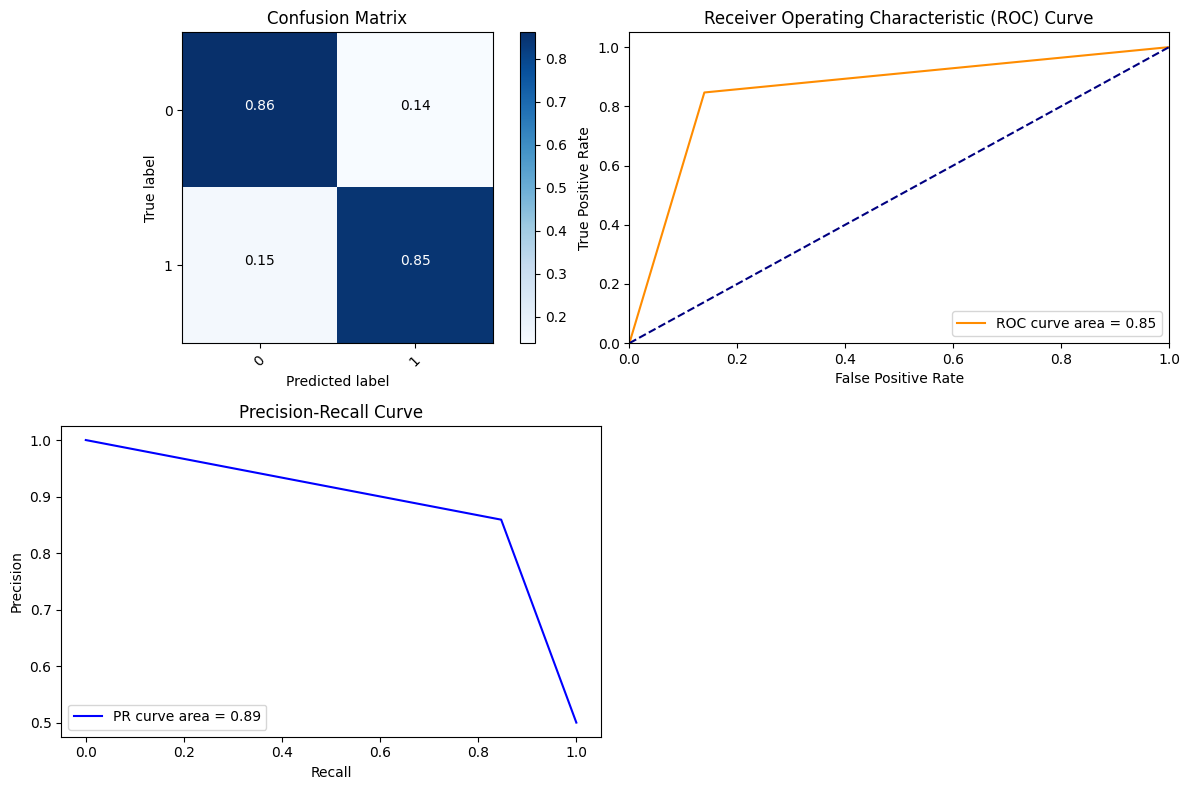

In [ ]:
plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 1)

ft_sc_normalized_conf_mat = ft_sc_conf_mat.astype('float') / ft_sc_conf_mat.sum(axis=1)[:, np.newaxis]
plot_confusion_matrix(ft_sc_normalized_conf_mat, classes=['0', '1'])
plt.subplot(2, 2, 2)
plot_roc_curve(ft_sc_fpr, ft_sc_tpr, ft_sc_roc_auc)
plt.subplot(2, 2, 3)
plot_precision_recall_curve(ft_sc_precision, ft_sc_recall, ft_sc_pr_auc)

plt.tight_layout()
plt.show()

## Sentence Similarity


In [ ]:
#fasttext_stsb_embeddings1 = [get_fasttext_embedding(text, model) for text in train_sentence_similarity_data['sentence1']]
#fasttext_stsb_embeddings2 = [get_fasttext_embedding(text, model) for text in train_sentence_similarity_data['sentence2']]

fasttext_stsb_embeddings1 = np.array([get_fasttext_embedding(text, ft_model) for text in train_sentence_similarity_data['sentence1']])
fasttext_stsb_embeddings2 = np.array([get_fasttext_embedding(text, ft_model) for text in train_sentence_similarity_data['sentence2']])
#ft_imdb_test_embeddings = np.array([get_fasttext_embedding(text.numpy().decode('utf-8'), ft_model) for text, label in imdb_test_data]

In [ ]:
ft_stsb_train_pairwise_similarity = cosine_similarity(fasttext_stsb_embeddings1, fasttext_stsb_embeddings2)[0] * 5

In [ ]:
ft_ss_pearson_corr, _ = pearsonr(ssim_train_labels, ft_stsb_train_pairwise_similarity)
ft_ss_spearman_corr, _ = spearmanr(ssim_train_labels, ft_stsb_train_pairwise_similarity)

print(f"Pearson Correlation: {ft_ss_pearson_corr:.3f}")
print(f"Spearman Correlation: {ft_ss_spearman_corr:.3f}")

Pearson Correlation: -0.062
Spearman Correlation: -0.059


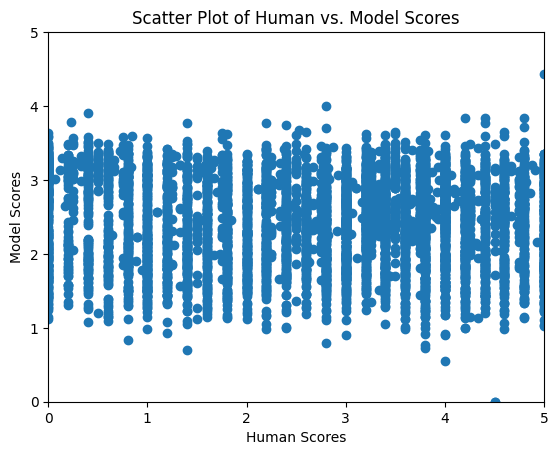

In [ ]:
import matplotlib.pyplot as plt

#ft_stsb_train_pairwise_similarity = cos_sim

plt.xlim(0,5)  # Set limits
plt.ylim(0,5)
plt.scatter(ssim_train_labels, ft_stsb_train_pairwise_similarity)
plt.xlabel('Human Scores')
plt.ylabel('Model Scores')
plt.title('Scatter Plot of Human vs. Model Scores')
plt.show()

## Sentence Entailment

In [ ]:
import tensorflow as tf
from transformers import BertTokenizer, TFBertModel

def batch_cosine_similarity(embeddings1, embeddings2):
    normalized_embeddings1 = tf.nn.l2_normalize(embeddings1, axis=1)
    normalized_embeddings2 = tf.nn.l2_normalize(embeddings2, axis=1)
    return tf.reduce_sum(tf.multiply(normalized_embeddings1, normalized_embeddings2), axis=1)

snli_ft_train_dataset = tf.data.Dataset.from_tensor_slices((snli_train_premises, snli_train_hypotheses, snli_train_labels))
snli_ft_validation_dataset = tf.data.Dataset.from_tensor_slices((snli_validation_premises, snli_validation_hypotheses, snli_validation_labels))

batch_size = 512
snli_ft_train_dataset = snli_ft_train_dataset.batch(batch_size)
snli_ft_train_cat_embeddings = []

for batch_premises, batch_hypotheses, batch_labels in snli_ft_train_dataset:
    snli_ft_train_premise_embeddings = [np.array(get_embedding(premise, ft_model)) for premise in batch_premises.numpy()]
    snli_ft_train_hypothesis_embeddings = [np.array(get_embedding(hypothesis, ft_model)) for hypothesis in batch_hypotheses.numpy()]
    snli_ft_train_cat_embeddings.append(np.hstack((snli_ft_train_premise_embeddings, snli_ft_train_hypothesis_embeddings)))


In [ ]:
snli_ft_val_dataset = snli_ft_validation_dataset.batch(batch_size)
snli_ft_val_cat_embeddings = []
for batch_premises, batch_hypotheses, batch_labels in snli_ft_val_dataset:
    snli_ft_val_premise_embeddings = [np.array(get_embedding(premise, ft_model)) for premise in batch_premises.numpy()]
    snli_ft_val_hypothesis_embeddings = [np.array(get_embedding(hypothesis, ft_model)) for hypothesis in batch_hypotheses.numpy()]
    snli_ft_val_cat_embeddings.append(np.hstack((snli_ft_val_premise_embeddings, snli_ft_val_hypothesis_embeddings)))

In [ ]:
from keras.optimizers import Adam

embedding_dim = 600  # For 2 concatenated word2vec vectors

ft_se_model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(embedding_dim,)),
    tf.keras.layers.Dense(96, activation='relu'),
    tf.keras.layers.Dropout(0.2),

    tf.keras.layers.Dense(96, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(48, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    #tf.keras.layers.Dense(48, activation='relu'),
    #tf.keras.layers.Dropout(0.2),
    #tf.keras.layers.Dense(24, activation='relu'),
    #tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(3, activation='softmax')
])

opt = Adam()

ft_se_model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
snli_ft_train_flat_embeddings = []
for batch in snli_ft_train_cat_embeddings:
  for embedding in batch:
    snli_ft_train_flat_embeddings.append(np.array(embedding))

snli_ft_train_flat_embeddings = np.array(snli_ft_train_flat_embeddings)

In [ ]:
snli_ft_val_flat_embeddings = []
for batch in snli_ft_val_cat_embeddings:
  for embedding in batch:
    snli_ft_val_flat_embeddings.append(np.array(embedding))

snli_ft_val_flat_embeddings = np.array(snli_ft_val_flat_embeddings)

In [ ]:
ft_se_model_fit = ft_se_model.fit(snli_ft_train_flat_embeddings, np.array(snli_train_labels), epochs=10)

Epoch 1/10
17168/17168 [==============================] - 54s 3ms/step - loss: 1.0532 - accuracy: 0.4384
Epoch 2/10
17168/17168 [==============================] - 52s 3ms/step - loss: 1.0348 - accuracy: 0.4611
Epoch 3/10
17168/17168 [==============================] - 52s 3ms/step - loss: 1.0274 - accuracy: 0.4703
Epoch 4/10
17168/17168 [==============================] - 52s 3ms/step - loss: 1.0235 - accuracy: 0.4750
Epoch 5/10
17168/17168 [==============================] - 52s 3ms/step - loss: 1.0206 - accuracy: 0.4771
Epoch 6/10
17168/17168 [==============================] - 53s 3ms/step - loss: 1.0186 - accuracy: 0.4801
Epoch 7/10
17168/17168 [==============================] - 53s 3ms/step - loss: 1.0168 - accuracy: 0.4820
Epoch 8/10
17168/17168 [==============================] - 52s 3ms/step - loss: 1.0153 - accuracy: 0.4836
Epoch 9/10
17168/17168 [==============================] - 52s 3ms/step - loss: 1.0141 - accuracy: 0.4847
Epoch 10/10
17168/17168 [==============================

In [ ]:
ft_se_model_eval = ft_se_model.evaluate(snli_ft_val_flat_embeddings, np.array(snli_validation_labels))

308/308 [==============================] - 1s 2ms/step - loss: 1.0003 - accuracy: 0.5028


# BERT

In [ ]:
#from transformers import BertTokenizer, TFBertModel
#import torch

bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = TFBertModel.from_pretrained('bert-base-uncased')

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [ ]:
def bert_encode_text_list(text):
    encoded = bert_tokenizer.encode(
        text,  # Make sure it's a proper string
        add_special_tokens=True,
        max_length=512,
        return_attention_mask=True,
        return_token_type_ids=False,
        padding='max_length',
        truncation=True
    )

    return encoded['input_ids'], encoded['attention_mask']

# Function to encode texts
def bert_encode_texts(text, label):
    encoded = bert_tokenizer.encode_plus(
        text.numpy().decode('utf-8'),  # Make sure it's a proper string
        add_special_tokens=True,
        max_length=512,
        return_attention_mask=True,
        return_token_type_ids=False,
        padding='max_length',
        truncation=True
    )
    return encoded['input_ids'], encoded['attention_mask'], label

# Wrap the encoding function in a TensorFlow op
def bert_tf_encode(text, label):
    result_input_ids, result_attention_mask, result_label = tf.py_function(
        bert_encode_texts,
        inp=[text, label],
        Tout=[tf.int32, tf.int32, tf.int64]
    )
    result_input_ids.set_shape([512])
    result_attention_mask.set_shape([512])
    result_label.set_shape([])

    return result_input_ids, result_attention_mask, result_label

def bert_tf_generic_encode(text):
    result_input_ids, result_attention_mask, result_label = tf.py_function(
        bert_encode_texts,
        inp=[text],
        Tout=[tf.int32, tf.int32, tf.int64]
    )
    result_input_ids.set_shape([512])
    result_attention_mask.set_shape([512])
    result_label.set_shape([])

    return result_input_ids, result_attention_mask, result_label

# Function to save embeddings
def save_embeddings(dataset, filename):
    with h5py.File(filename, 'w') as h5f:
        for i, (input_ids_batch, attention_mask_batch, labels_batch) in enumerate(dataset):
            # Generate embeddings for the batch
            outputs = bert_model(input_ids_batch, attention_mask=attention_mask_batch)
            last_hidden_state = outputs.last_hidden_state
            embeddings = last_hidden_state[:, 0, :]
            #embeddings_list.append(embeddings)

            # Save the embeddings and labels to the HDF5 file
            h5f.create_dataset(f'embeddings_{i}', data=embeddings.numpy())
            h5f.create_dataset(f'labels_{i}', data=labels_batch.numpy())

def save_bert_word_embeddings_to_file(dataset, filename):
    with h5py.File(filename, 'w') as h5f:
        #for i, (input_ids_batch, attention_mask_batchh) in enumerate(dataset):
        for item in dataset:
            # Generate embeddings for the batch
            outputs = bert_model(item)
            last_hidden_state = outputs.last_hidden_state
            embeddings = last_hidden_state[:, 0, :]
            #embeddings_list.append(embeddings)

            # Save the embeddings and labels to the HDF5 file
            h5f.create_dataset(f'embeddings_{i}', data=embeddings.numpy())
            h5f.create_dataset(f'labels_{i}', data=labels_batch.numpy())


## Word Similarity

In [ ]:
#import pandas as pd
#from scipy.spatial.distance import cosine
#from scipy.stats import spearmanr
#from transformers import BertTokenizer, BertModel
#import torch

sim_data = load_wordsim_353()

def cosine_similarity(vec1, vec2):
    return np.dot(vec1, vec2.T) / (np.linalg.norm(vec1) * np.linalg.norm(vec2))

# Function to get BERT embedding for a given word
def get_bert_word_embedding(word):
    inputs = bert_tokenizer(word, return_tensors="tf")
    outputs = bert_model(**inputs)
    # Take the average of all token embeddings to get a single word embedding
    embedding = outputs.last_hidden_state[:,1,:]
    return np.array(embedding)

# Iterate over the dataset and calculate cosine similarity for each pair
cos_similarities = []
for _, row in sim_data.iterrows():
    embedding1 = get_bert_word_embedding(row['Word 1'])
    embedding2 = get_bert_word_embedding(row['Word 2'])
    cos_similarity = cosine_similarity(embedding1, embedding2)
    cos_similarities.append(cos_similarity[0][0] * 10)

# Add the model's cosine similarities to the DataFrame
sim_data['BERT Cosine Similarity'] = cos_similarities

# Evaluate the model by comparing its similarities to the human judgments
correlation, _ = spearmanr(sim_data['Human (mean)'], sim_data['BERT Cosine Similarity'])
print(f"Spearman correlation between BERT cosine similarities and human judgments: {correlation:.3f}")


Spearman correlation between BERT cosine similarities and human judgments: 0.253


In [ ]:
bert_ws_computed_scores = sim_data['BERT Cosine Similarity']

bert_ws_pearson_corr, _ = pearsonr(human_scores, bert_ws_computed_scores)
bert_ws_spearman_corr, _ = spearmanr(human_scores, bert_ws_computed_scores)

print(f"Pearson Correlation: {bert_ws_pearson_corr:.3f}")
print(f"Spearman Correlation: {bert_ws_spearman_corr:.3f}")

Pearson Correlation: 0.187
Spearman Correlation: 0.253


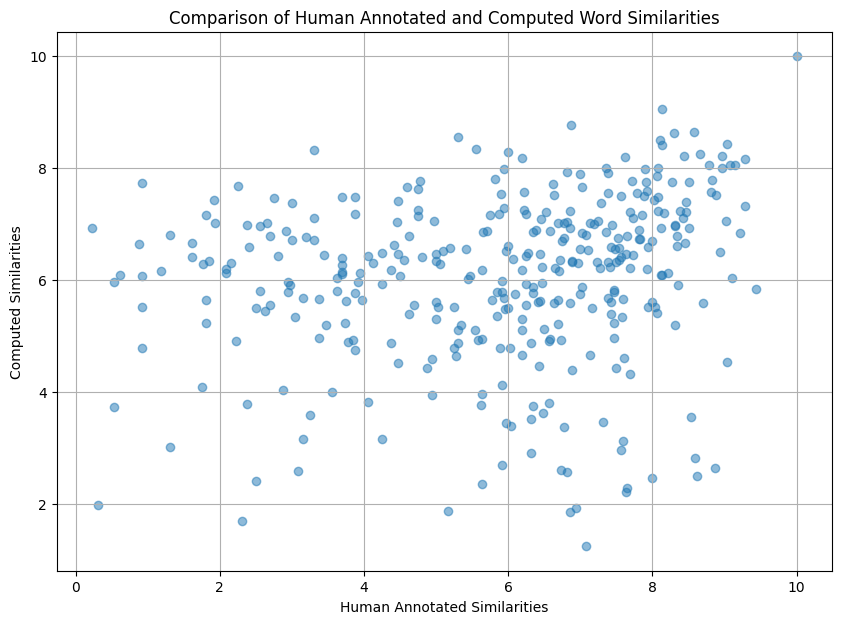

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 7))
plt.scatter(sim_data['Human (mean)'], sim_data['BERT Cosine Similarity'], alpha=0.5)
plt.xlabel('Human Annotated Similarities')
plt.ylabel('Computed Similarities')
plt.title('Comparison of Human Annotated and Computed Word Similarities')
plt.grid(True)
plt.show()

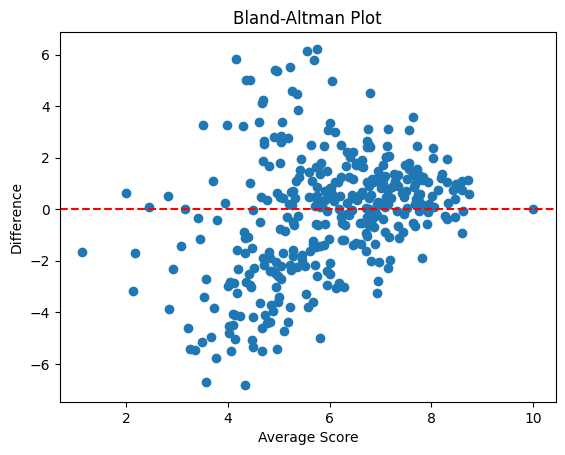

In [ ]:
averages = (human_scores + sim_data['BERT Cosine Similarity']) / 2
differences = human_scores - sim_data['BERT Cosine Similarity']

plt.scatter(averages, differences)
plt.axhline(0, color='red', linestyle='--')  # Line of no difference
plt.xlabel('Average Score')
plt.ylabel('Difference')
plt.title('Bland-Altman Plot')
plt.show()

## Sentiment Classification

In [ ]:
#def get_bert_embedding(text):
#    # Assuming 'model' is your pre-trained embedding model
#    # and 'preprocess' is a function to preprocess your text
#    preprocessed_text = preprocess(text.numpy().decode('utf-8'))
#    embedding = np.mean([model.wv[word] for word in preprocessed_text if word in model.wv], axis=0)
#    return embedding


**This cell only needs to be run to generate and save the embeddings files**

In [ ]:
#import tensorflow as tf
#import tensorflow_datasets as tfds
#from transformers import BertTokenizer, TFBertModel
#import h5py
#import numpy as np

# Apply the function to the dataset
#batch_size = 128  # Adjust batch size according to your GPU memory
#ds_imdb_train_encoded = imdb_train_data.map(bert_tf_encode).batch(batch_size)
#ds_imdb_test_encoded = imdb_test_data.map(bert_tf_encode).batch(batch_size)

# Extract embeddings and save them to files
#save_embeddings(ds_imdb_train_encoded, 'bert_imdb_train_embeddings.h5')
#save_embeddings(ds_imdb_test_encoded, 'bert_imdb_test_embeddings.h5')

In [ ]:
import gc
gc.collect()

18725

In [ ]:

def load_embeddings_and_labels(filename):
    with h5py.File(filename, 'r') as h5f:
        # Initialize lists to hold embeddings and labels
        embeddings_list = []
        labels_list = []

        # Iterate over batches in the HDF5 file
        for i in range(len(h5f.keys()) // 2):  # Assuming there's an equal number of embedding and label datasets
            embeddings_batch = h5f[f'embeddings_{i}'][:]
            labels_batch = h5f[f'labels_{i}'][:]
            embeddings_list.append(embeddings_batch)
            labels_list.append(labels_batch)

        # Concatenate all batches to form the full datasets
        embeddings = np.concatenate(embeddings_list, axis=0)
        labels = np.concatenate(labels_list, axis=0)

    return embeddings, labels

# Load embeddings and labels
bert_imdb_train_embeddings, bert_imdb_train_labels = load_embeddings_and_labels('bert_imdb_train_embeddings.h5')
bert_imdb_test_embeddings, bert_imdb_test_labels = load_embeddings_and_labels('bert_imdb_test_embeddings.h5')

# Ensure the embeddings are shaped as a 2D array (num_examples, embedding_dimension)
print(bert_imdb_train_embeddings.shape)  # Should print (num_examples, embedding_dimension)

# Initialize and train the logistic regression model
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(bert_imdb_train_embeddings, bert_imdb_train_labels)

(25000, 768)


LogisticRegression(max_iter=1000)

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Predict on the test set
bert_imdb_test_predictions = log_reg.predict(bert_imdb_test_embeddings)

# Calculate the accuracy
bert_sc_accuracy = accuracy_score(bert_imdb_test_labels, bert_imdb_test_predictions)
print(f'Accuracy: {bert_sc_accuracy * 100}%')

bert_sc_classification_report = classification_report(bert_imdb_test_labels, bert_imdb_test_predictions, output_dict=True)


Accuracy: 87.244%


In [ ]:
# Predict probabilities
bert_sc_test_probabilities = log_reg.predict_proba(bert_imdb_test_embeddings)[:, 1]

# Get confusion matrix
bert_sc_conf_mat = confusion_matrix(imdb_test_labels, bert_sc_test_probabilities > 0.5)

# ROC curve
bert_sc_fpr, bert_sc_tpr, _ = roc_curve(imdb_test_labels, bert_sc_test_probabilities)
bert_sc_roc_auc = auc(bert_sc_fpr, bert_sc_tpr)

# Precision-Recall curve
bert_sc_precision, bert_sc_recall, _ = precision_recall_curve(imdb_test_labels, bert_sc_test_probabilities)
bert_sc_pr_auc = auc(bert_sc_recall, bert_sc_precision)

#bert_accuracy, bert_sc_conf_mat, bert_sc_roc_auc, bert_sc_pr_auc


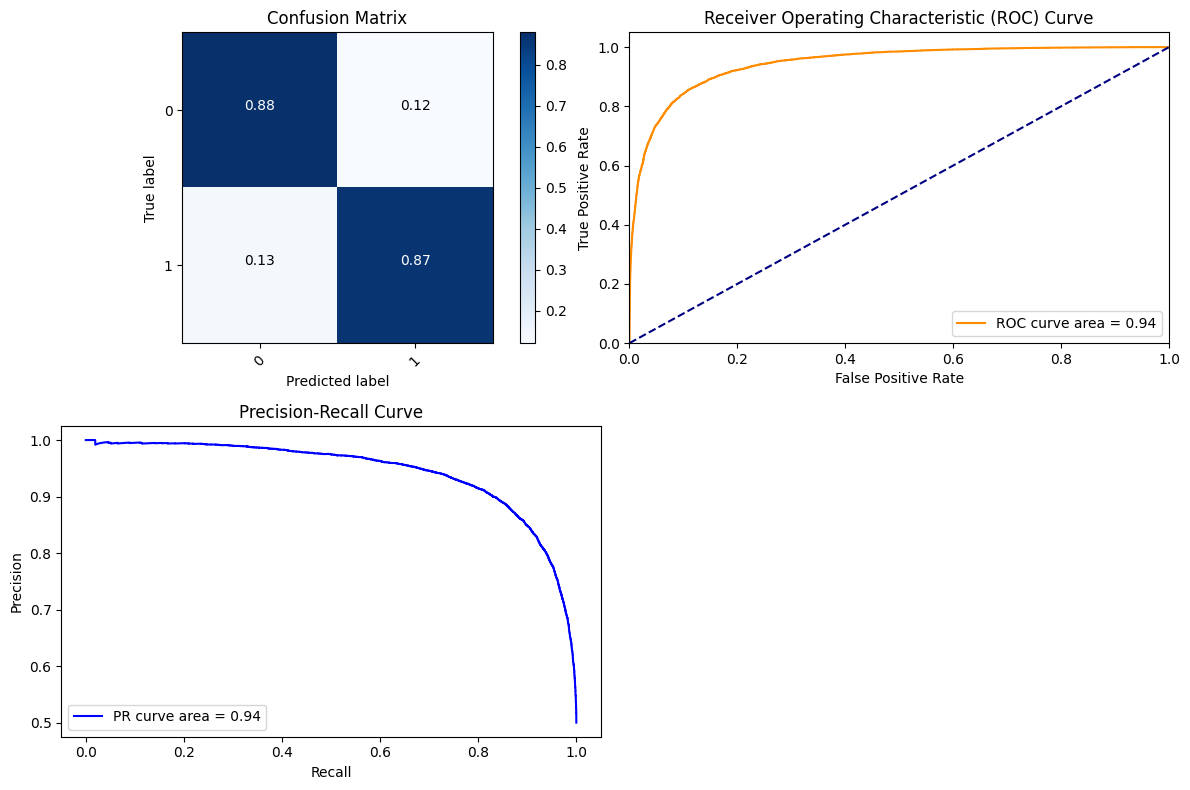

In [ ]:
plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 1)

bert_sc_normalized_conf_mat = bert_sc_conf_mat.astype('float') / bert_sc_conf_mat.sum(axis=1)[:, np.newaxis]
plot_confusion_matrix(bert_sc_normalized_conf_mat, classes=['0', '1'])
plt.subplot(2, 2, 2)
plot_roc_curve(bert_sc_fpr, bert_sc_tpr, bert_sc_roc_auc)
plt.subplot(2, 2, 3)
plot_precision_recall_curve(bert_sc_precision, bert_sc_recall, bert_sc_pr_auc)

plt.tight_layout()
plt.show()

## Sentence Entailment

In [ ]:
import tensorflow as tf
from transformers import BertTokenizer, TFBertModel

def bert_encode(texts):
    inputs = bert_tokenizer(list(texts), return_tensors='tf', padding=True, truncation=True, max_length=512)
    outputs = bert_model(inputs)
    #print(outputs.last_hidden_state)
    return outputs.last_hidden_state[:,0,:]

def batch_cosine_similarity(embeddings1, embeddings2):
    normalized_embeddings1 = tf.nn.l2_normalize(embeddings1, axis=1)
    normalized_embeddings2 = tf.nn.l2_normalize(embeddings2, axis=1)
    return tf.reduce_sum(tf.multiply(normalized_embeddings1, normalized_embeddings2), axis=1)

snli_train_dataset = tf.data.Dataset.from_tensor_slices((snli_train_premises, snli_train_hypotheses, snli_train_labels))
snli_validation_dataset = tf.data.Dataset.from_tensor_slices((snli_validation_premises, snli_validation_hypotheses, snli_validation_labels))

batch_size = 512
snli_train_dataset = snli_train_dataset.batch(batch_size)
cat_embeddings = []

for batch_premises, batch_hypotheses, batch_labels in snli_train_dataset:
    snli_train_premise_embeddings = bert_encode(batch_premises.numpy().astype(str))
    snli_train_hypothesis_embeddings = bert_encode(batch_hypotheses.numpy().astype(str))
    cat_embeddings.append(np.hstack((snli_train_premise_embeddings, snli_train_hypothesis_embeddings)))


In [ ]:
snli_validation_cat_embeddings = []
snli_validation_dataset = snli_validation_dataset.batch(batch_size)
for batch_premises, batch_hypotheses, batch_labels in snli_validation_dataset:
    snli_validation_premise_embeddings = bert_encode(batch_premises.numpy().astype(str))
    snli_validation_hypothesis_embeddings = bert_encode(batch_hypotheses.numpy().astype(str))
    snli_validation_cat_embeddings.append(np.hstack((snli_validation_premise_embeddings, snli_validation_hypothesis_embeddings)))

In [ ]:
from keras.optimizers import Adam

embedding_dim = 1536  # For 2 concatenated BERT vectors

bert_se_model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(embedding_dim,)),
    tf.keras.layers.Dense(96, activation='relu'),
    tf.keras.layers.Dropout(0.2),

    tf.keras.layers.Dense(96, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(48, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    #tf.keras.layers.Dense(48, activation='relu'),
    #tf.keras.layers.Dropout(0.2),
    #tf.keras.layers.Dense(24, activation='relu'),
    #tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(3, activation='softmax')
])

opt = Adam()

bert_se_model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
flat_embeddings = []
for batch in cat_embeddings:
  for embedding in batch:
    flat_embeddings.append(embedding)

In [ ]:
flat_validation_bert_embeddings = []
for batch in snli_validation_cat_embeddings:
  for embedding in batch:
    flat_validation_bert_embeddings.append(embedding)

In [ ]:
flat_embeddings = np.array(flat_embeddings)
snli_train_labels = np.array(snli_train_labels)

flat_validation_bert_embeddings = np.array(flat_validation_bert_embeddings)
snli_validation_labels = np.array(snli_validation_labels)

In [ ]:
gc.collect()

186

In [ ]:
bert_se_model_fit = bert_se_model.fit(flat_embeddings, np.array(snli_train_labels), epochs=10)

Epoch 1/10
17168/17168 [==============================] - 53s 3ms/step - loss: 0.9457 - accuracy: 0.5336
Epoch 2/10
17168/17168 [==============================] - 52s 3ms/step - loss: 0.9107 - accuracy: 0.5646
Epoch 3/10
17168/17168 [==============================] - 52s 3ms/step - loss: 0.8942 - accuracy: 0.5824
Epoch 4/10
17168/17168 [==============================] - 52s 3ms/step - loss: 0.8853 - accuracy: 0.5899
Epoch 5/10
17168/17168 [==============================] - 52s 3ms/step - loss: 0.8787 - accuracy: 0.5954
Epoch 6/10
17168/17168 [==============================] - 52s 3ms/step - loss: 0.8755 - accuracy: 0.5983
Epoch 7/10
17168/17168 [==============================] - 52s 3ms/step - loss: 0.8882 - accuracy: 0.5900
Epoch 8/10
17168/17168 [==============================] - 52s 3ms/step - loss: 0.8965 - accuracy: 0.5881
Epoch 9/10
17168/17168 [==============================] - 52s 3ms/step - loss: 0.8932 - accuracy: 0.5895
Epoch 10/10
17168/17168 [==============================

In [ ]:
bert_se_model_eval = bert_se_model.evaluate(flat_validation_bert_embeddings, snli_validation_labels)

308/308 [==============================] - 1s 2ms/step - loss: 0.8627 - accuracy: 0.6197


## Sentence Similarity

In [ ]:
def get_bert_embeddings(sentences):
    encoded_input = bert_tokenizer(sentences, padding=True, truncation=True, max_length=512, return_tensors='tf')
    with tf.GradientTape():
        output = bert_model(encoded_input)
    return output.last_hidden_state[:, 0, :]

dataset = train_sentence_similarity_data
similarities = []

for example in dataset:
    embeddings1 = np.array(get_bert_embeddings(example['sentence1']))
    embeddings2 = np.array(get_bert_embeddings(example['sentence2']))
    similarity = cosine_similarity(embeddings1, embeddings2)
    #print(similarity[0][0])
    similarities.append(similarity[0][0])


In [ ]:
similarities[0]

0.9894366

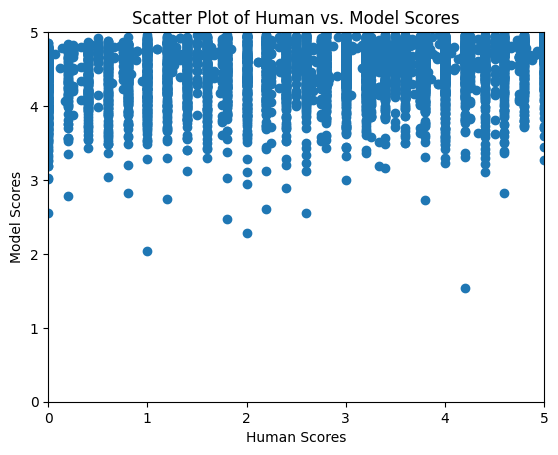

In [ ]:
import matplotlib.pyplot as plt

#train_labels = train_sentence_similarity_data['label']
bert_ssim_train_pairwise_similarity = [similarity * 5 for similarity in similarities]

plt.xlim(0,5)  # Set limits
plt.ylim(0,5)
plt.scatter(ssim_train_labels, bert_ssim_train_pairwise_similarity)
plt.xlabel('Human Scores')
plt.ylabel('Model Scores')
plt.title('Scatter Plot of Human vs. Model Scores')
plt.show()

In [ ]:
bert_ss_pearson_corr, _ = pearsonr(ssim_train_labels, bert_ssim_train_pairwise_similarity)
bert_ss_spearman_corr, _ = spearmanr(ssim_train_labels,bert_ssim_train_pairwise_similarity)

print(f"Pearson Correlation: {bert_ss_pearson_corr:.3f}")
print(f"Spearman Correlation: {bert_ss_spearman_corr:.3f}")

Pearson Correlation: 0.223
Spearman Correlation: 0.228


# S-BERT

In [ ]:
from sentence_transformers import SentenceTransformer

s_bert_model = SentenceTransformer('all-MiniLM-L6-v2')

.gitattributes:   0%|          | 0.00/1.18k [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.6k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

data_config.json:   0%|          | 0.00/39.3k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

train_script.py:   0%|          | 0.00/13.2k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

## Word Similarity

In [ ]:
# Iterate over the dataset and calculate cosine similarity for each pair
cos_similarities = []
for _, row in sim_data.iterrows():
    embedding1 = s_bert_model.encode(row['Word 1'])
    embedding2 = s_bert_model.encode(row['Word 2'])
    cos_similarity = cosine_similarity(embedding1, embedding2)
    cos_similarities.append(cos_similarity * 10)

# Add the model's cosine similarities to the DataFrame
sbert_cos_sim = cos_similarities

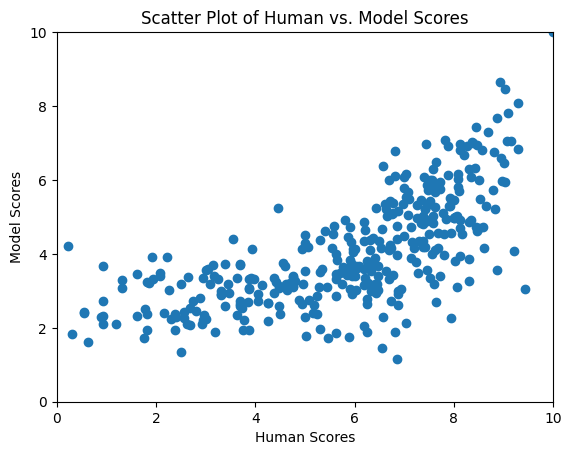

In [ ]:
plt.xlim(0,10)  # Set limits
plt.ylim(0,10)
plt.scatter(human_scores, sbert_cos_sim)
plt.xlabel('Human Scores')
plt.ylabel('Model Scores')
plt.title('Scatter Plot of Human vs. Model Scores')
plt.show()

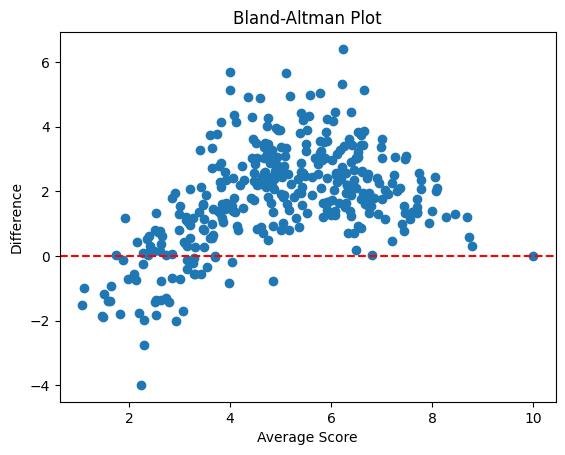

In [ ]:
averages = (human_scores + sbert_cos_sim) / 2
differences = human_scores - sbert_cos_sim

plt.scatter(averages, differences)
plt.axhline(0, color='red', linestyle='--')  # Line of no difference
plt.xlabel('Average Score')
plt.ylabel('Difference')
plt.title('Bland-Altman Plot')
plt.show()

In [ ]:
sbert_ws_pearson_corr, _ = pearsonr(human_scores, sbert_cos_sim)
sbert_ws_spearman_corr, _ = spearmanr(human_scores,sbert_cos_sim)

print(f"Pearson Correlation: {sbert_ws_pearson_corr:.3f}")
print(f"Spearman Correlation: {sbert_ws_spearman_corr:.3f}")

Pearson Correlation: 0.687
Spearman Correlation: 0.729


## Sentiment Classification

In [ ]:
sbert_imdb_train_embeddings = np.array([s_bert_model.encode(text.numpy().decode('utf-8')) for text, label in imdb_train_data])
sbert_imdb_test_embeddings = np.array([s_bert_model.encode(text.numpy().decode('utf-8')) for text, label in imdb_test_data])

**logistic regression**

In [ ]:
sbert_sc_clf = LogisticRegression()
sbert_sc_clf.fit(sbert_imdb_train_embeddings, imdb_train_labels)

sbert_sc_test_predictions = sbert_sc_clf.predict(sbert_imdb_test_embeddings)

In [ ]:
# Predict probabilities
sbert_sc_test_probabilities = sbert_sc_clf.predict_proba(sbert_imdb_test_embeddings)[:, 1]

# Get confusion matrix
sbert_sc_conf_mat = confusion_matrix(imdb_test_labels, sbert_sc_test_probabilities > 0.5)

# ROC curve
sbert_sc_fpr, sbert_sc_tpr, _ = roc_curve(imdb_test_labels, sbert_sc_test_probabilities)
sbert_sc_roc_auc = auc(sbert_sc_fpr, sbert_sc_tpr)

# Precision-Recall curve
sbert_sc_precision, sbert_sc_recall, _ = precision_recall_curve(imdb_test_labels, sbert_sc_test_probabilities)
sbert_sc_pr_auc = auc(sbert_sc_recall, sbert_sc_precision)

sbert_sc_accuracy = accuracy_score(imdb_test_labels, sbert_sc_test_predictions)
#accuracy, conf_mat, roc_auc, pr_auc
sbert_sc_classification_report = classification_report(imdb_test_labels, sbert_sc_test_predictions, output_dict=True)
print(sbert_sc_classification_report)

{'0': {'precision': 0.8086473621578738, 'recall': 0.81544, 'f1-score': 0.8120294761999602, 'support': 12500}, '1': {'precision': 0.8138765631302944, 'recall': 0.80704, 'f1-score': 0.810443864229765, 'support': 12500}, 'accuracy': 0.81124, 'macro avg': {'precision': 0.8112619626440841, 'recall': 0.81124, 'f1-score': 0.8112366702148626, 'support': 25000}, 'weighted avg': {'precision': 0.8112619626440841, 'recall': 0.81124, 'f1-score': 0.8112366702148627, 'support': 25000}}


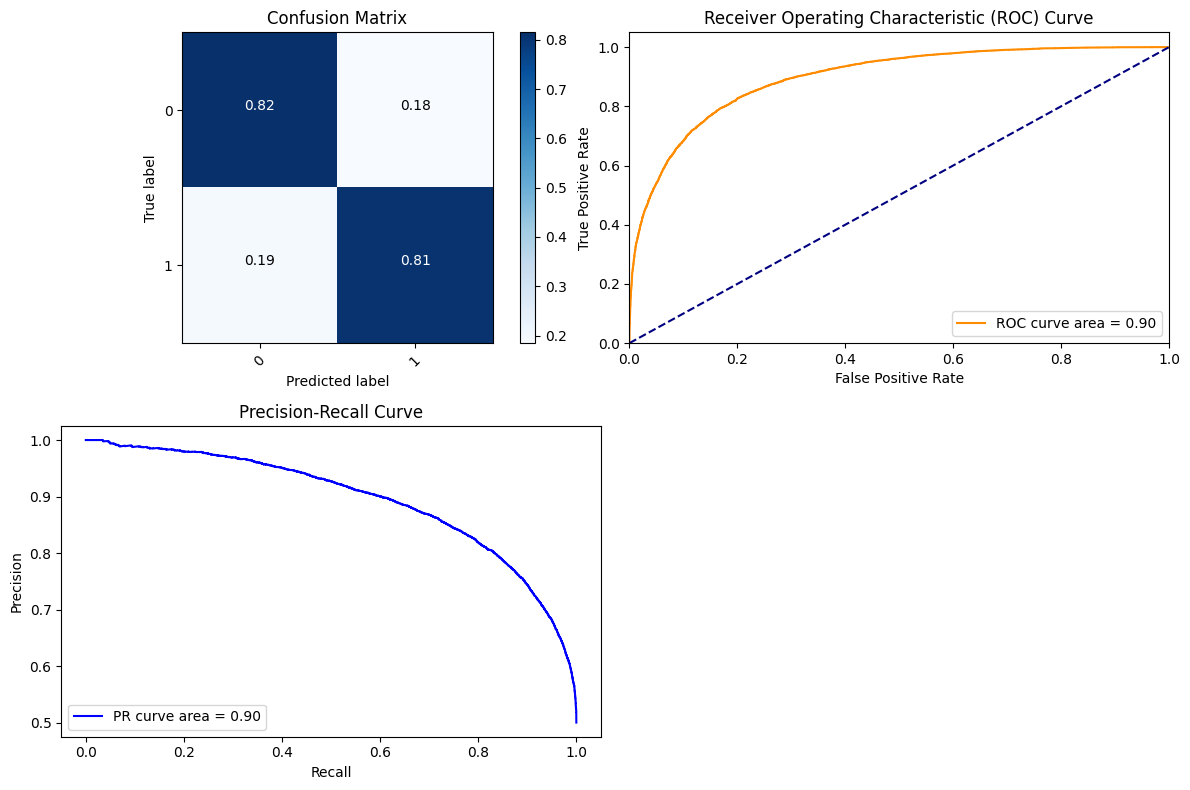

In [ ]:
plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 1)

sbert_sc_normalized_conf_mat = sbert_sc_conf_mat.astype('float') / sbert_sc_conf_mat.sum(axis=1)[:, np.newaxis]
plot_confusion_matrix(sbert_sc_normalized_conf_mat, classes=['0', '1'])
plt.subplot(2, 2, 2)
plot_roc_curve(sbert_sc_fpr, sbert_sc_tpr, sbert_sc_roc_auc)
plt.subplot(2, 2, 3)
plot_precision_recall_curve(sbert_sc_precision, sbert_sc_recall, sbert_sc_pr_auc)

plt.tight_layout()
plt.show()

## Sentence Similarity

In [ ]:

sbert_ssim_similarities = []

embeddings1 = normalize(s_bert_model.encode(train_sentence_similarity_data['sentence1']))
embeddings2 = normalize(s_bert_model.encode(train_sentence_similarity_data['sentence2']))


In [ ]:
sbert_ssim_pairwise_similarity = (embeddings1 * embeddings2).sum(axis=1) * 5

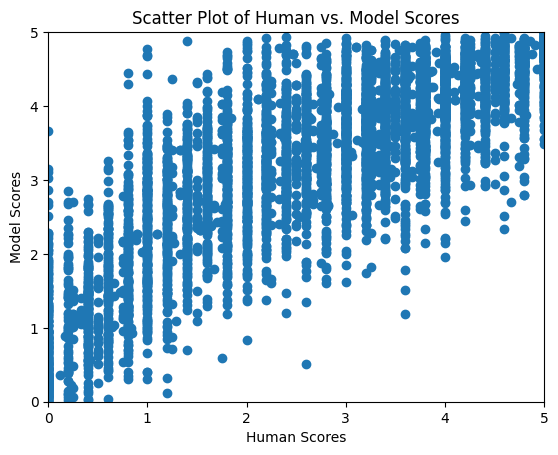

In [ ]:
import matplotlib.pyplot as plt

train_labels = train_sentence_similarity_data['label']

plt.xlim(0,5)  # Set limits
plt.ylim(0,5)
plt.scatter(train_labels, sbert_ssim_pairwise_similarity)
plt.xlabel('Human Scores')
plt.ylabel('Model Scores')
plt.title('Scatter Plot of Human vs. Model Scores')
plt.show()

In [ ]:
sbert_ssim_pearson_corr, _ = pearsonr(train_labels, sbert_ssim_pairwise_similarity)
sbert_ssim_spearman_corr, _ = spearmanr(train_labels, sbert_ssim_pairwise_similarity)

print(f"Pearson Correlation: {sbert_ssim_pearson_corr:.3f}")
print(f"Spearman Correlation: {sbert_ssim_spearman_corr:.3f}")

Pearson Correlation: 0.835
Spearman Correlation: 0.810


## Sentence Entailment

In [ ]:
snli_train_dataset = tf.data.Dataset.from_tensor_slices((snli_train_premises, snli_train_hypotheses, snli_train_labels))
snli_val_dataset = tf.data.Dataset.from_tensor_slices((snli_validation_premises, snli_validation_hypotheses, snli_validation_labels))

In [ ]:
batch_size = 512
snli_train_dataset = snli_train_dataset.batch(batch_size)
cat_embeddings = []

for batch_premises, batch_hypotheses, batch_labels in snli_train_dataset:
    snli_train_premise_embeddings = s_bert_model.encode(batch_premises.numpy().astype(str))
    snli_train_hypothesis_embeddings = s_bert_model.encode(batch_hypotheses.numpy().astype(str))
    cat_embeddings.append(np.hstack((snli_train_premise_embeddings, snli_train_hypothesis_embeddings)))

In [ ]:
batch_size = 512
snli_val_dataset = tf.data.Dataset.from_tensor_slices((snli_validation_premises, snli_validation_hypotheses, snli_validation_labels))
snli_val_dataset = snli_val_dataset.batch(batch_size)
val_cat_embeddings = []

for batch_premises, batch_hypotheses, batch_labels in snli_val_dataset:
    snli_val_premise_embeddings = s_bert_model.encode(batch_premises.numpy().astype(str))
    snli_val_hypothesis_embeddings = s_bert_model.encode(batch_hypotheses.numpy().astype(str))
    val_cat_embeddings.append(np.hstack((snli_val_premise_embeddings, snli_val_hypothesis_embeddings)))

In [ ]:
len(snli_train_hypothesis_embeddings[0])

384

In [ ]:
# Convert the validation dataset to a list of tuples
validation_data = list(snli_validation_dataset.unbatch().as_numpy_iterator())

# Initialize the list for concatenated embeddings
snli_validation_cat_embeddings = []

# Process each example individually
for premise, hypothesis, label in validation_data:
    # The premise and hypothesis are expected to be in byte format, so decode them to string
    premise_text = premise.decode('utf-8')
    hypothesis_text = hypothesis.decode('utf-8')

    # Encode the texts
    premise_embedding = s_bert_model.encode([premise_text])[0]
    hypothesis_embedding = s_bert_model.encode([hypothesis_text])[0]

    # Concatenate the embeddings and append to the list
    concatenated_embedding = np.hstack((premise_embedding, hypothesis_embedding))
    snli_validation_cat_embeddings.append(concatenated_embedding)


In [ ]:
from keras.optimizers import Adam

embedding_dim = 768  # For 2 concatenated S-BERT vectors

sbert_se_model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(embedding_dim,)),
    tf.keras.layers.Dense(96, activation='relu'),
    tf.keras.layers.Dropout(0.2),

    tf.keras.layers.Dense(96, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(48, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    #tf.keras.layers.Dense(48, activation='relu'),
    #tf.keras.layers.Dropout(0.2),
    #tf.keras.layers.Dense(24, activation='relu'),
    #tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(3, activation='softmax')
])

opt = Adam()

sbert_se_model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
flat_train_sbert_embeddings = []
for batch in cat_embeddings:
  for embedding in batch:
    flat_train_sbert_embeddings.append(embedding)

In [ ]:
flat_validation_sbert_embeddings = []
#for batch in snli_validation_cat_embeddings:
for batch in val_cat_embeddings:
  for embedding in batch:
    flat_validation_sbert_embeddings.append(embedding)

In [ ]:
flat_train_sbert_embeddings = np.array(flat_train_sbert_embeddings)
snli_train_labels = np.array(snli_train_labels)

flat_validation_sbert_embeddings = np.array(flat_validation_sbert_embeddings)
snli_validation_labels = np.array(snli_validation_labels)

In [ ]:
sbert_se_model_fit = sbert_se_model.fit(flat_train_sbert_embeddings, np.array(snli_train_labels), epochs=10)

Epoch 1/10
17168/17168 [==============================] - 51s 3ms/step - loss: 0.7007 - accuracy: 0.6989
Epoch 2/10
17168/17168 [==============================] - 50s 3ms/step - loss: 0.6259 - accuracy: 0.7394
Epoch 3/10
17168/17168 [==============================] - 51s 3ms/step - loss: 0.6007 - accuracy: 0.7520
Epoch 4/10
17168/17168 [==============================] - 51s 3ms/step - loss: 0.5863 - accuracy: 0.7593
Epoch 5/10
17168/17168 [==============================] - 50s 3ms/step - loss: 0.5747 - accuracy: 0.7650
Epoch 6/10
17168/17168 [==============================] - 50s 3ms/step - loss: 0.5657 - accuracy: 0.7698
Epoch 7/10
17168/17168 [==============================] - 51s 3ms/step - loss: 0.5594 - accuracy: 0.7731
Epoch 8/10
17168/17168 [==============================] - 51s 3ms/step - loss: 0.5534 - accuracy: 0.7762
Epoch 9/10
17168/17168 [==============================] - 51s 3ms/step - loss: 0.5486 - accuracy: 0.7783
Epoch 10/10
17168/17168 [==============================

In [ ]:
sbert_se_model_eval = sbert_se_model.evaluate(flat_validation_sbert_embeddings, np.array(snli_validation_labels))

308/308 [==============================] - 1s 2ms/step - loss: 0.5124 - accuracy: 0.7904


# Universal Sentence Encoder

In [ ]:
use_embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

## Sentiment Classification - IMDB dataset

In [ ]:
#train_data, test_data = load_imdb_dataset()

# Extract the reviews and labels
#imdb_train_texts, imdb_train_labels = zip(*[(text, label) for text, label in imdb_train_data])
#imdb_test_texts, imdb_test_labels = zip(*[(text, label) for text, label in imdb_test_data])

In [ ]:
gc.collect()

0

In [ ]:
# Unfortunately have to do this iteratively because of memory constraints
use_sc_train_embeddings = [use_embed([text]).numpy() for text, label in imdb_train_data]
use_sc_test_embeddings = [use_embed([text]).numpy() for text, label in imdb_test_data]

In [ ]:
#np_use_imdb_train_embeddings = np.array(imdb_train_embeddings)

 **Logistic Regressio**n

In [ ]:
#imdb_train_labels = [label.numpy() for label in imdb_train_labels]
#imdb_test_labels = [label.numpy() for label in imdb_test_labels]

In [ ]:
flattened_use_sc_training_embeddings = [embedding.reshape(-1) for embedding in use_sc_train_embeddings]
flattened_use_sc_test_embeddings = [embedding.reshape(-1) for embedding in use_sc_test_embeddings]

In [ ]:
#imdb_train_embeddings_np = np.array(flattened_imdb_use_training_embeddings)
#imdb_train_labels_np = np.array(imdb_train_labels)
#imdb_test_labels_np = np.array(imdb_test_labels)

#print("Embeddings shape:", imdb_train_embeddings_np.shape)
#print("Labels shape:", imdb_train_labels_np.shape)

use_sc_clf = LogisticRegression().fit(flattened_use_sc_training_embeddings, imdb_train_labels)


In [ ]:
#imdb_use_test_embeddings_np = np.array(flattened_imdb_use_test_embeddings)
use_sc_ypred = use_sc_clf.predict(flattened_use_sc_test_embeddings)

In [ ]:
use_sc_accuracy = accuracy_score(use_sc_ypred, imdb_test_labels)

In [ ]:
# Predict probabilities
use_sc_test_probabilities = use_sc_clf.predict_proba(flattened_use_sc_test_embeddings)[:, 1]

# Get confusion matrix
use_sc_conf_mat = confusion_matrix(imdb_test_labels, use_sc_test_probabilities > 0.5)

# ROC curve
use_sc_fpr, use_sc_tpr, _ = roc_curve(imdb_test_labels, use_sc_test_probabilities)
use_sc_roc_auc = auc(use_sc_fpr, use_sc_tpr)

# Precision-Recall curve
use_sc_precision, use_sc_recall, _ = precision_recall_curve(imdb_test_labels, use_sc_test_probabilities)
use_sc_pr_auc = auc(use_sc_recall, use_sc_precision)

#accuracy, conf_mat, roc_auc, pr_auc
use_sc_classification_report = classification_report(imdb_test_labels, use_sc_ypred, output_dict=True)


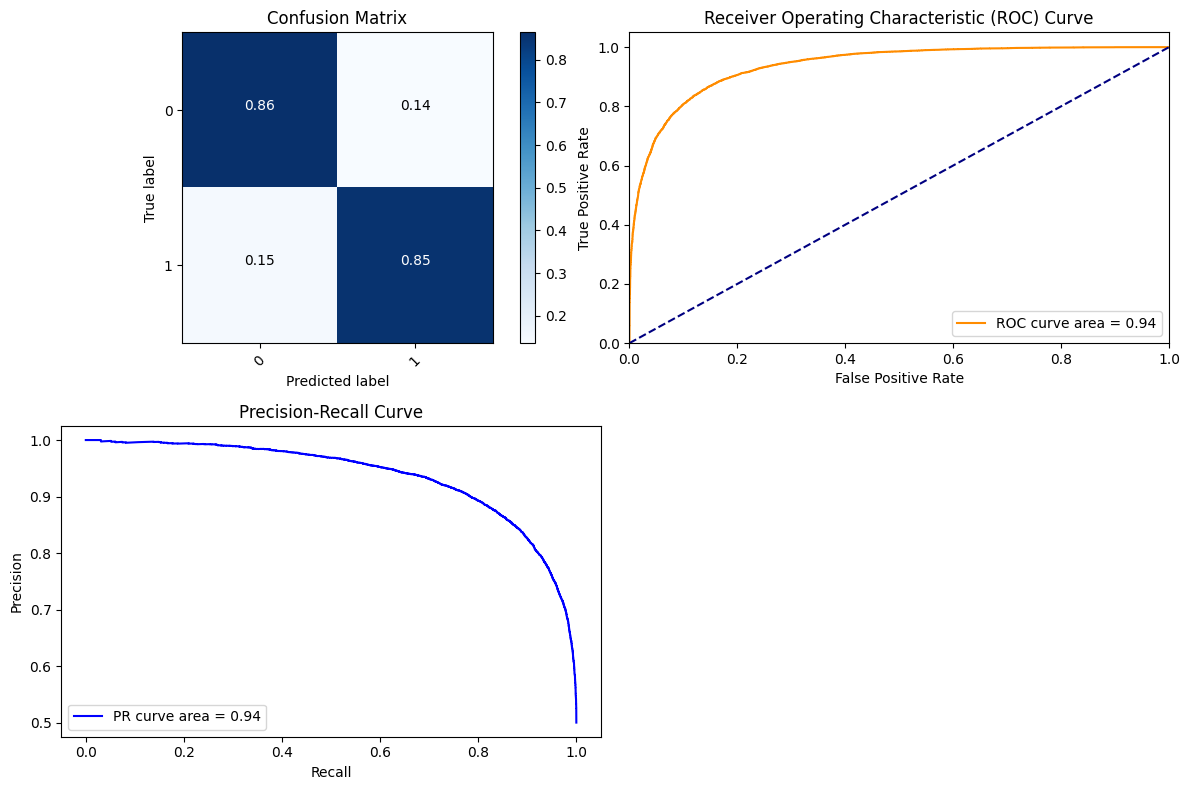

In [ ]:
plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 1)

use_sc_normalized_conf_mat = use_sc_conf_mat.astype('float') / use_sc_conf_mat.sum(axis=1)[:, np.newaxis]
plot_confusion_matrix(use_sc_normalized_conf_mat, classes=['0', '1'])
plt.subplot(2, 2, 2)
plot_roc_curve(use_sc_fpr, use_sc_tpr, use_sc_roc_auc)
plt.subplot(2, 2, 3)
plot_precision_recall_curve(use_sc_precision, use_sc_recall, use_sc_pr_auc)

plt.tight_layout()
plt.show()

##Word Similarity



In [ ]:
wordsim_use_embedding1 = normalize(use_embed(sim_data['Word 1']))
wordsim_use_embedding2 = normalize(use_embed(sim_data['Word 2']))

In [ ]:
wordsim_use_cosine_sim = (wordsim_use_embedding1 * wordsim_use_embedding2).sum(axis=1)

In [ ]:
from scipy.stats import spearmanr

correlation, _ = spearmanr(human_scores, wordsim_use_cosine_sim * 10)
print(f"Spearman's rank correlation: {correlation}")

Spearman's rank correlation: 0.6903941009151461


In [ ]:
use_ws_pearson_corr, _ = pearsonr(human_scores, wordsim_use_cosine_sim)
use_ws_spearman_corr, _ = spearmanr(human_scores, wordsim_use_cosine_sim)

print(f"Pearson Correlation: {use_ws_pearson_corr:.3f}")
print(f"Spearman Correlation: {use_ws_spearman_corr:.3f}")

Pearson Correlation: 0.659
Spearman Correlation: 0.690


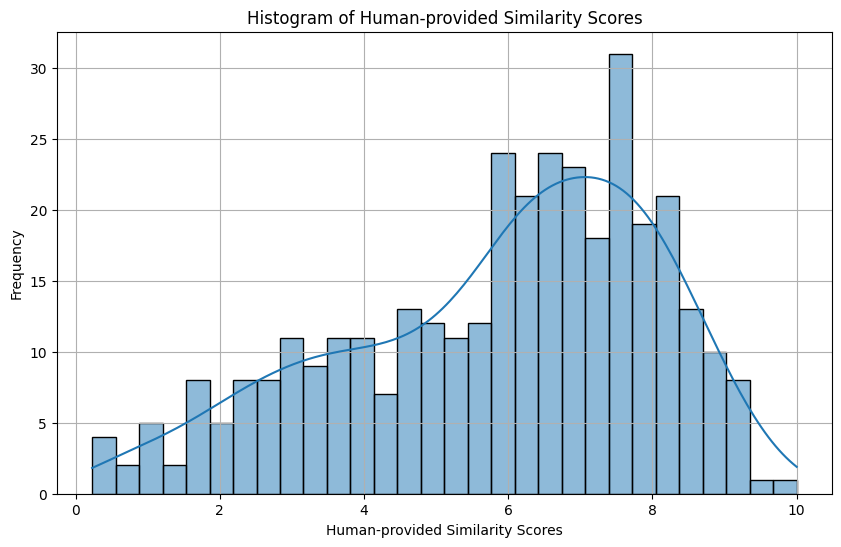

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(human_scores, bins=30, kde=True)
plt.title("Histogram of Human-provided Similarity Scores")
plt.xlabel("Human-provided Similarity Scores")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

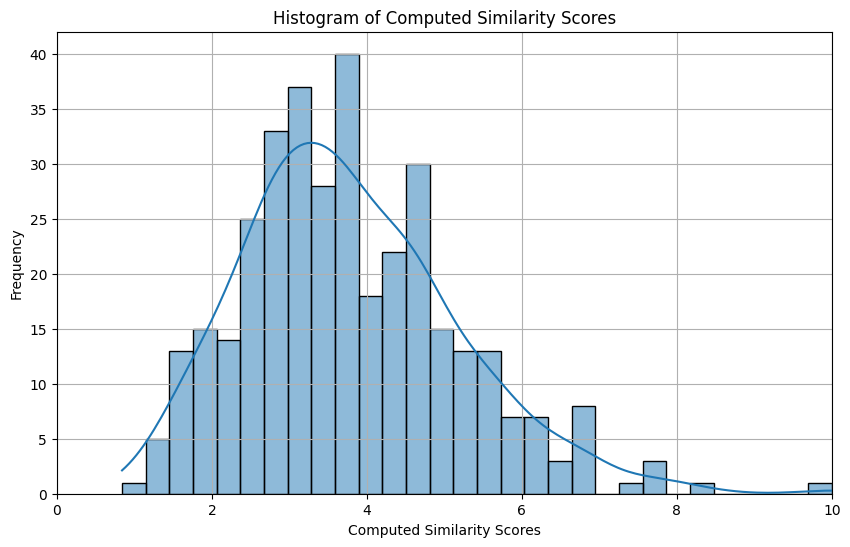

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(wordsim_use_cosine_sim * 10, bins=30, kde=True)
plt.title("Histogram of Computed Similarity Scores")
plt.xlim(0,10)
plt.xlabel("Computed Similarity Scores")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

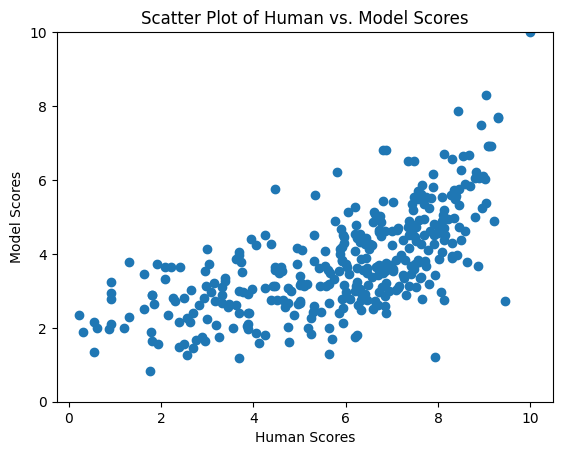

In [ ]:
plt.ylim(0,10)
plt.scatter(human_scores, wordsim_use_cosine_sim * 10)
plt.xlabel('Human Scores')
plt.ylabel('Model Scores')
plt.title('Scatter Plot of Human vs. Model Scores')
plt.show()

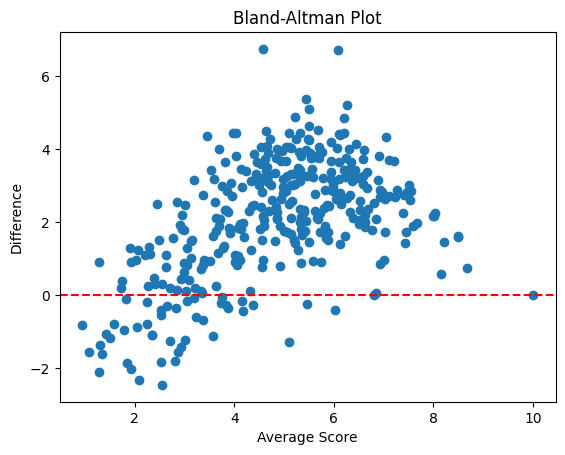

In [ ]:
averages = (human_scores + (wordsim_use_cosine_sim * 10)) / 2
differences = human_scores - (wordsim_use_cosine_sim * 10)

plt.scatter(averages, differences)
plt.axhline(0, color='red', linestyle='--')  # Line of no difference
plt.xlabel('Average Score')
plt.ylabel('Difference')
plt.title('Bland-Altman Plot')
plt.show()

##Sentence Similarity

In [ ]:
#sentence_similarity_data = load_rice_stsb()

In [ ]:
#train_sentence_similarity_data = sentence_similarity_data['train']
#test_sentence_similarity_data = sentence_similarity_data['test']
#validation_sentence_similarity_data = sentence_similarity_data['validation']

In [ ]:
ssim_use_train_embed1 = use_embed(train_sentence_similarity_data['sentence1'])
ssim_use_train_embed2 = use_embed(train_sentence_similarity_data['sentence2'])

In [ ]:
ssim_use_validation_embed1 = use_embed(validation_sentence_similarity_data['sentence1'])
ssim_use_validation_embed2 = use_embed(validation_sentence_similarity_data['sentence2'])
ssim_use_validation_labels = validation_sentence_similarity_data['label']


In [ ]:
# Compute pairwise cosine similarity for each pair of embeddings
normalized_ssim_use_train_embed1 = normalize(ssim_use_train_embed1)
normalized_ssim_use_train_embed2 = normalize(ssim_use_train_embed2)
#normalized_validation_embed1 = normalize(validation_embed1)
#normalized_validation_embed2 = normalize(validation_embed2)

ssim_use_train_pairwise_similarity = (normalized_ssim_use_train_embed1 * normalized_ssim_use_train_embed2).sum(axis=1)
#validation_pairwise_similarity = (normalized_validation_embed1 * normalized_validation_embed2).sum(axis=1)
#validation_similarity = (normalized_validation_embed1 * normalized_validation_embed2).sum(axis=1)

ssim_use_train_pairwise_similarity = ssim_use_train_pairwise_similarity * 5
#validation_pairwise_similarity = validation_pairwise_similarity * 5

In [ ]:
(normalized_ssim_use_train_embed1 * normalized_ssim_use_train_embed2).sum(axis=1)

array([0.92120639, 0.91691129, 0.86602675, ..., 0.39458518, 0.34542325,
       0.06031461])

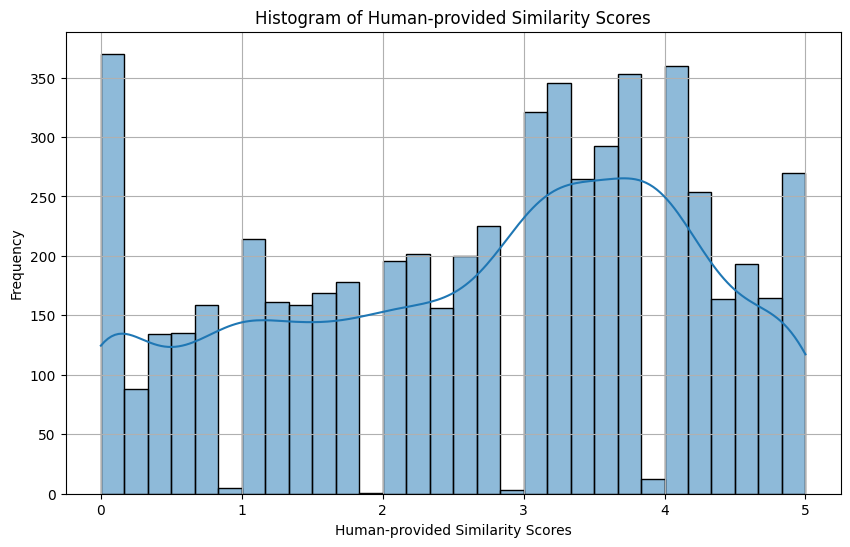

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(ssim_train_labels, bins=30, kde=True)
plt.title("Histogram of Human-provided Similarity Scores")
plt.xlabel("Human-provided Similarity Scores")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()


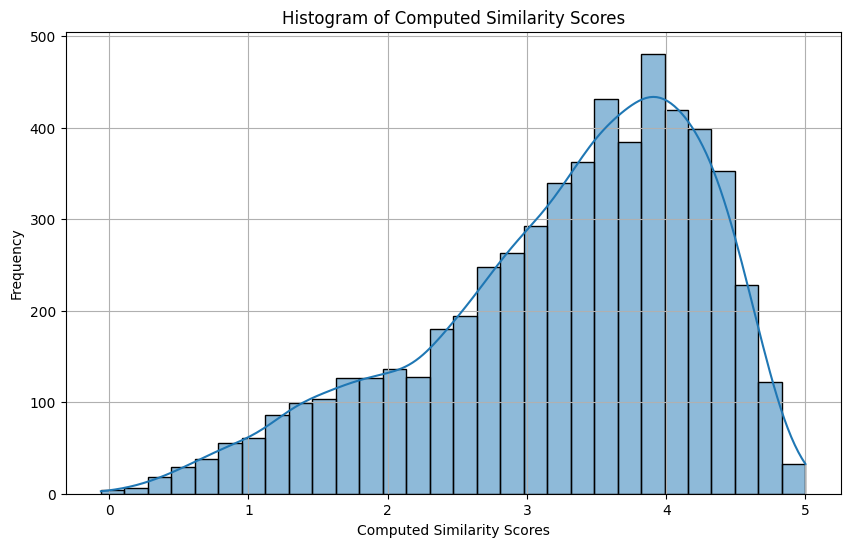

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.histplot(ssim_use_train_pairwise_similarity, bins=30, kde=True)
plt.title("Histogram of Computed Similarity Scores")
plt.xlabel("Computed Similarity Scores")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()


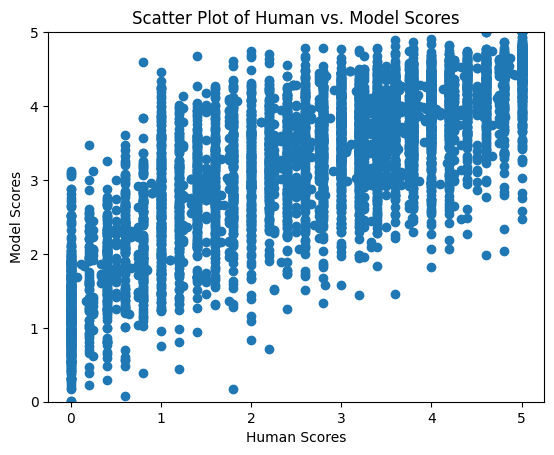

In [ ]:
import matplotlib.pyplot as plt

plt.ylim(0,5)
plt.scatter(train_labels, ssim_use_train_pairwise_similarity)
plt.xlabel('Human Scores')
plt.ylabel('Model Scores')
plt.title('Scatter Plot of Human vs. Model Scores')
plt.show()

In [ ]:
use_ssim_pearson_corr, _ = pearsonr(ssim_train_labels, ssim_use_train_pairwise_similarity)
use_ssim_spearman_corr, _ = spearmanr(ssim_train_labels, ssim_use_train_pairwise_similarity)

print(f"Pearson Correlation: {use_ssim_pearson_corr:.3f}")
print(f"Spearman Correlation: {use_ssim_spearman_corr:.3f}")

Pearson Correlation: 0.782
Spearman Correlation: 0.750


## Sentence Entailment

In [ ]:
gc.collect()

28642

In [ ]:
use_snli_train_cat_embeddings = []
use_snli_validation_cat_embeddings = []


snli_train_dataset = tf.data.Dataset.from_tensor_slices((snli_train_premises, snli_train_hypotheses, snli_train_labels))
snli_validation_dataset = tf.data.Dataset.from_tensor_slices((snli_validation_premises, snli_validation_hypotheses, snli_validation_labels))

batch_size = 512
use_snli_train_dataset = snli_train_dataset.batch(batch_size)

for batch_premises, batch_hypotheses, batch_labels in use_snli_train_dataset:
    snli_train_premise_embeddings = use_embed(batch_premises)
    snli_train_hypothesis_embeddings = use_embed(batch_hypotheses)
    use_snli_train_cat_embeddings.append(np.hstack((snli_train_premise_embeddings, snli_train_hypothesis_embeddings)))

In [ ]:
use_snli_validation_dataset = snli_validation_dataset.batch(batch_size)

for batch_premises, batch_hypotheses, batch_labels in use_snli_validation_dataset:
    snli_validation_premise_embeddings = use_embed(batch_premises)
    snli_validation_hypothesis_embeddings = use_embed(batch_hypotheses)
    use_snli_validation_cat_embeddings.append(np.hstack((snli_validation_premise_embeddings, snli_validation_hypothesis_embeddings)))

In [ ]:
flat_use_snli_train_embeddings = []
for batch in use_snli_train_cat_embeddings:
  for embedding in batch:
    flat_use_snli_train_embeddings.append(embedding)

flat_use_snli_test_embeddings = []
for batch in use_snli_validation_cat_embeddings:
  for embedding in batch:
    flat_use_snli_test_embeddings.append(embedding)

**Logistic Regression**

Even scaling the features, the regressor fails to converge. Should try a solver that handles multiclass tasks better.

In [ ]:
from sklearn.preprocessing import StandardScaler

#scaler = StandardScaler()
#scaled_features = scaler.fit_transform(features)

regressor = LogisticRegression().fit(flat_use_snli_train_embeddings, snli_train_labels)
#snli_test_predicted_scores = regressor.predict(np.hstack([flat_snli_test_embeddings, snli_test_hypothesis_embeddings]))
#conf_mat = confusion_matrix(snli_y_test, snli_test_predicted_scores)
#print(conf_mat)
#print(r2_score(snli_y_test, snli_test_predicted_scores))


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


**Neural Net**

Created a fairly small net to highlight the relative power of the embeddings.


In [ ]:
import tensorflow as tf

embedding_dim = 512  # For USE
concatenated_dim = 2 * embedding_dim  # Since we concatenated premise and hypothesis embeddings

use_se_model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(concatenated_dim,)),
    tf.keras.layers.Dense(96, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(96, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(48, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(3, activation='softmax')
])

use_se_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [ ]:
use_se_model_fit = use_se_model.fit(np.array(flat_use_snli_train_embeddings), snli_train_labels, epochs=10)

Epoch 1/10
17168/17168 [==============================] - 53s 3ms/step - loss: 0.5745 - accuracy: 0.7661
Epoch 2/10
17168/17168 [==============================] - 52s 3ms/step - loss: 0.5043 - accuracy: 0.8007
Epoch 3/10
17168/17168 [==============================] - 53s 3ms/step - loss: 0.4847 - accuracy: 0.8092
Epoch 4/10
17168/17168 [==============================] - 53s 3ms/step - loss: 0.4722 - accuracy: 0.8150
Epoch 5/10
17168/17168 [==============================] - 52s 3ms/step - loss: 0.4644 - accuracy: 0.8187
Epoch 6/10
17168/17168 [==============================] - 52s 3ms/step - loss: 0.4571 - accuracy: 0.8215
Epoch 7/10
17168/17168 [==============================] - 53s 3ms/step - loss: 0.4525 - accuracy: 0.8237
Epoch 8/10
17168/17168 [==============================] - 53s 3ms/step - loss: 0.4475 - accuracy: 0.8262
Epoch 9/10
17168/17168 [==============================] - 53s 3ms/step - loss: 0.4443 - accuracy: 0.8271
Epoch 10/10
17168/17168 [==============================

The validation accuracy is comparable to the training accuracy.

In [ ]:
use_se_model_eval = use_se_model.evaluate(np.array(flat_use_snli_test_embeddings), snli_validation_labels)

308/308 [==============================] - 1s 2ms/step - loss: 0.5396 - accuracy: 0.7929


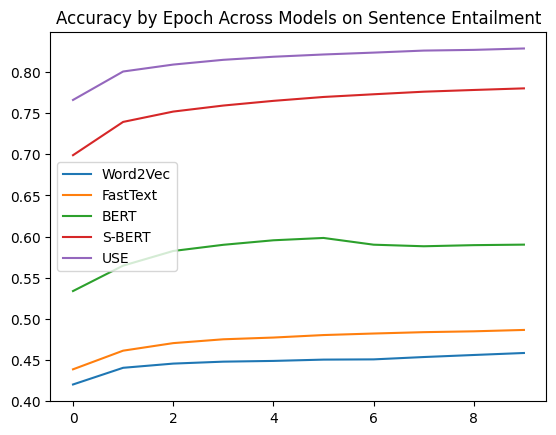

In [ ]:
plt.plot(w2v_se_model_fit.history['accuracy'], label="Word2Vec")
plt.plot(ft_se_model_fit.history['accuracy'], label="FastText")
plt.plot(bert_se_model_fit.history['accuracy'], label="BERT")
plt.plot(sbert_se_model_fit.history['accuracy'], label="S-BERT")
plt.plot(use_se_model_fit.history['accuracy'], label="USE")
plt.title("Accuracy by Epoch Across Models on Sentence Entailment")
plt.legend(loc='center left')
plt.show()

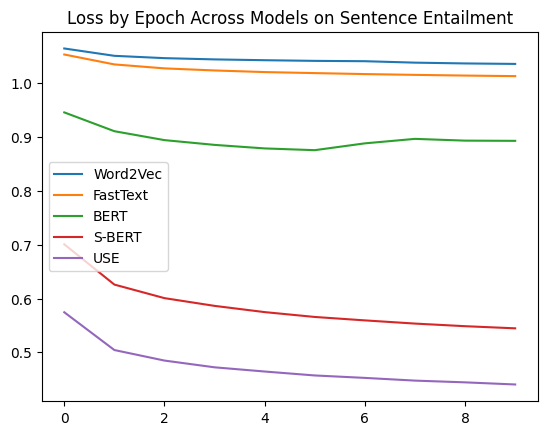

In [ ]:
plt.plot(w2v_se_model_fit.history['loss'], label="Word2Vec")
plt.plot(ft_se_model_fit.history['loss'], label="FastText")
plt.plot(bert_se_model_fit.history['loss'], label="BERT")
plt.plot(sbert_se_model_fit.history['loss'], label="S-BERT")
plt.plot(use_se_model_fit.history['loss'], label="USE")
plt.title("Loss by Epoch Across Models on Sentence Entailment")
plt.legend(loc='center left')
plt.show()

# Aggregate Analysis

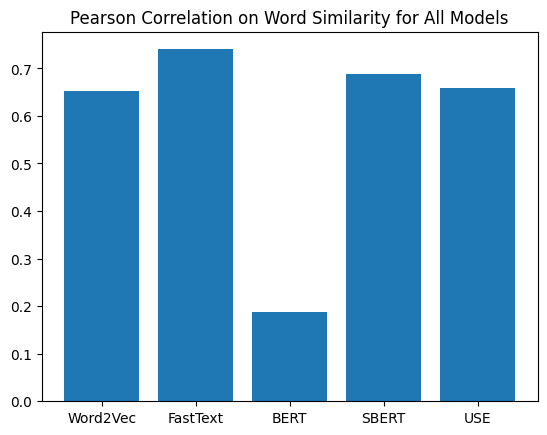

In [ ]:
results = [w2v_ws_pearson_corr, ft_ws_pearson_corr, bert_ws_pearson_corr, sbert_ws_pearson_corr, use_ws_pearson_corr]

# plot bargraph of results
plt.bar(range(len(results)), results)
plt.xticks(range(len(results)), ['Word2Vec', 'FastText', 'BERT', 'SBERT', 'USE'])
plt.title('Pearson Correlation on Word Similarity for All Models')
plt.show()

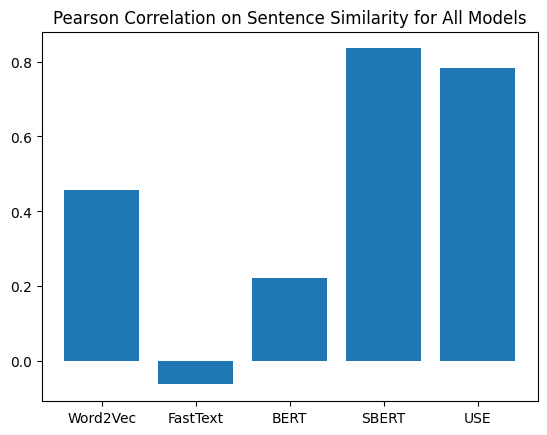

In [ ]:
results = [w2v_ss_pearson_corr, ft_ss_pearson_corr, bert_ss_pearson_corr, sbert_ssim_pearson_corr, use_ssim_pearson_corr]

# plot bargraph of results
plt.bar(range(len(results)), results)
plt.xticks(range(len(results)), ['Word2Vec', 'FastText', 'BERT', 'SBERT', 'USE'])
plt.title('Pearson Correlation on Sentence Similarity for All Models')
plt.show()

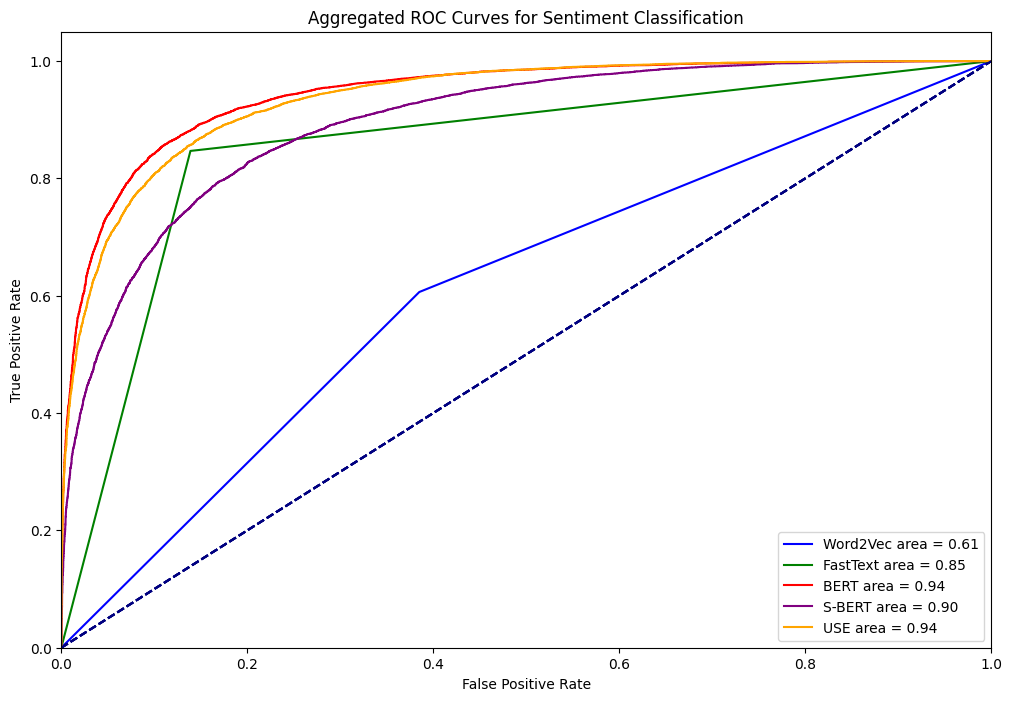

In [ ]:
plt.figure(figsize=(12, 8))

plot_roc_curve(w2v_sc_fpr, w2v_sc_tpr, w2v_sc_roc_auc, model='Word2Vec', color='blue')
plot_roc_curve(ft_sc_fpr, ft_sc_tpr, ft_sc_roc_auc, model='FastText', color='green')
plot_roc_curve(bert_sc_fpr, bert_sc_tpr, bert_sc_roc_auc, model='BERT', color='red')
plot_roc_curve(sbert_sc_fpr, sbert_sc_tpr, sbert_sc_roc_auc, model='S-BERT', color='purple')
plot_roc_curve(use_sc_fpr, use_sc_tpr, use_sc_roc_auc, model='USE', color='orange')
plt.title('Aggregated ROC Curves for Sentiment Classification')
plt.show()

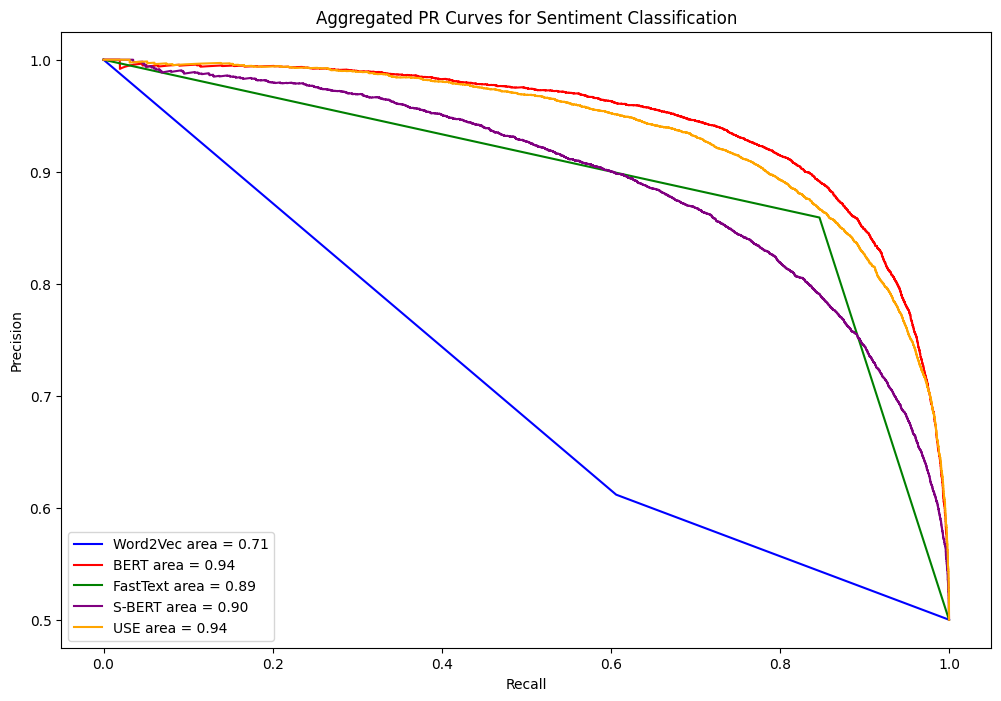

In [ ]:
plt.figure(figsize=(12, 8))
plot_precision_recall_curve(w2v_sc_precision, w2v_sc_recall, w2v_sc_pr_auc, model= 'Word2Vec', color='blue')
plot_precision_recall_curve(bert_sc_precision, bert_sc_recall, bert_sc_pr_auc, model= 'BERT', color='red')
plot_precision_recall_curve(ft_sc_precision, ft_sc_recall, ft_sc_pr_auc, model= 'FastText', color='green')
plot_precision_recall_curve(sbert_sc_precision, sbert_sc_recall, sbert_sc_pr_auc, model= 'S-BERT', color='purple')
plot_precision_recall_curve(use_sc_precision, use_sc_recall, use_sc_pr_auc, model= 'USE', color='orange')
plt.title('Aggregated PR Curves for Sentiment Classification')
plt.show()

In [ ]:
import pandas as pd

# Data from your experiments
data = {
    "Model": ["Word2Vec", "FastText", "BERT", "S-BERT", "USE"],
    "Word Similarity (Pearson)": [w2v_ws_pearson_corr, ft_ws_pearson_corr, bert_ws_pearson_corr, sbert_ws_pearson_corr, use_ws_pearson_corr],
    "Word Similarity (Spearman)": [w2v_ws_spearman_corr, ft_ws_spearman_corr, bert_ws_spearman_corr, sbert_ws_spearman_corr, use_ws_spearman_corr],
    "Sentence Similarity (Pearson)": [w2v_ss_pearson_corr, ft_ss_pearson_corr, bert_ss_pearson_corr, sbert_ssim_pearson_corr, use_ssim_pearson_corr],
    "Sentence Similarity (Spearman)": [w2v_ss_spearman_corr, ft_ss_spearman_corr, bert_ss_spearman_corr, sbert_ssim_spearman_corr, use_ssim_spearman_corr],
    "Sentiment Classification (Accuracy)": [w2v_sc_accuracy, ft_sc_accuracy, bert_sc_accuracy, sbert_sc_accuracy, use_sc_accuracy],
    #"Sentence Entailment (Accuracy)": [w2v_se]
}

# Creating a DataFrame
df = pd.DataFrame(data)

# Setting 'Model' as the index for better readability
df.set_index("Model", inplace=True)

# Displaying the DataFrame
print(df)


          Word Similarity (Pearson)  Word Similarity (Spearman)  \
Model                                                             
Word2Vec                   0.652535                    0.700017   
FastText                   0.740108                    0.791390   
BERT                       0.187387                    0.253010   
S-BERT                     0.687306                    0.728898   
USE                        0.658890                    0.690394   

          Sentence Similarity (Pearson)  Sentence Similarity (Spearman)  \
Model                                                                     
Word2Vec                       0.457890                        0.473997   
FastText                      -0.062151                       -0.059137   
BERT                           0.223127                        0.228383   
S-BERT                         0.834883                        0.810024   
USE                            0.782056                        0.749716   

    

In [ ]:
df

,Word Similarity (Pearson),Word Similarity (Spearman),Sentence Similarity (Pearson),Sentence Similarity (Spearman),Sentiment Classification (Accuracy)
Model,,,,,
Word2Vec,0.652535,0.700017,0.457890,0.473997,0.61068
FastText,0.740108,0.791390,-0.062151,-0.059137,0.85396
BERT,0.187387,0.253010,0.223127,0.228383,0.87244
S-BERT,0.687306,0.728898,0.834883,0.810024,0.81124
USE,0.658890,0.690394,0.782056,0.749716,0.85948
